# <span style='color:SteelBlue'>P4 - Anticipez les besoins en consommation de bâtiments</span>

![Logo Seattle](https://login.seattle.gov/static/media/logo.62be6fde.jpg)

# <span style='background:blue'>Introduction</span>

Pour atteindre l'objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation puisqu'ils génère 33% des émissions de gaz à effet de serre de la ville. Cette dernière a ainsi adopté un plan d'action climatique en 2013. Un relevé annuel des batiment de la ville permet de suivre l'évolution de leurs performances énergétiques. 

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émission et les consommations totale d'énergie des batiments. 

___

**Mission**

**Prédire les émissions de CO2 et la consommation totale d’énergie** non-mesurées de bâtiments non destinés à l’habitation de la ville de Seattle à partir d’un dataset de la ville. Pour cela je devrais :
1.	Réaliser une courte analyse exploratoire.
2.	Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Ce notebook présente la 1ère partie. Nous allons donc réaliser **une courte analyse exploratoire** après avoir nettoyé les données si nécessaire. Le but sera de déterminer les variables pertinentes ou d'en créer de nouvelles (feature engineering).

___

**Source des datasets**<br>
[Seattle Open Data](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)<br>

1 fichier CSV :
- 2016_Building_Energy_Benchmarking.csv
___


**Sommaire**

Importations des librairies utilisées dans ce notebook <br><br>
Créations des fonctions utilisées dans ce notebook <br><br>


**Etape 1 : Description des données**


MAJ

# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [1]:
# Librairies
import datetime
import os.path
import sys
import pandas as pd
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy
from scipy.stats import shapiro

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('Matplotlib    : ' + mpl.__version__)
print('Missingno     : ' + msno.__version__)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Scipy         : ' + scipy.__version__)
print('Seaborn       : ' + sns.__version__)

# Afficher heure lancement
maintenant = datetime.datetime.now().isoformat()
print('\nCode lancé le : ' + maintenant)

Version des librairies utilisées :
Python        : 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]
Matplotlib    : 3.8.0
Missingno     : 0.5.2
NumPy         : 1.26.0
Pandas        : 2.1.1
Scipy         : 1.11.3
Seaborn       : 0.13.0

Code lancé le : 2023-10-22T08:29:28.550312


In [2]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les définitions des indicateurs)
pd.set_option('display.max_row', 300)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

In [3]:
# Création d'1 palette de couleurs
colors_list = ['Gold', 'MediumPurple', 'DarkOrange', 'LimeGreen', 'Tomato', 'SteelBlue', 'SaddleBrown', 'DeepPink']

# Définit le style de la police pour le titre des graphiques
font_title = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 22}

# Définit le style de la police pour les axes du graphique
font_axe = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 16}

# Seuil de significativité des tests statistiques
seuil_significativite = 0.05

# <span style='background:grey'>Créations des fonctions utilisées dans ce notebook</span>

In [4]:
#                      NOMBRE DE LIGNES ET DE COLONNES
# ****************************************************************************

def print_nbr_ligne_col(df):
    """
    Procédure qui affiche le nombre de lignes et de colonnes du data frame
    
    :param: df : data frame à analyser (df)
    """
    
    # Affichage dimension du dataframe (linge et col)
    dim = df.shape
    print('{0} ligne(s) x {1} colonne(s)\n'.format(str(dim[0]), str(dim[1])))

In [5]:
#                              COMPTEUR TYPE DES VARIABLES
# ****************************************************************************

def compteur_type_variable(df, listing, tableau_repartition, graph):
    """
    Procédure qui affiche :
        - un listing des variables et leur type
        - un tableau de la répartition des variables par type
        - un graphique de répartition des variables par type avec un diagrmme   circulaire
    
    :param: df : data frame à analyser (df)
    :param: listing : True pour afficher le listing des variables (bool)
    :param: tableau_repartition : True pour afficher le tableau de répartition des variables (bool)
    :param: graph : True pour afficher le graph de répartition des variables (bool)
    """
    
    # Liste des variables + type
    if listing :
        print("-" * 100)
        print("Type de variable pour chacune des variables\n")
        display(df.info())
    
    # Type de variable et répartition
    if tableau_repartition :
        print("Répartition des types de variable")
        
        # Calcul du nombre de type de variable et leur répartition
        type_nbr = df.dtypes.value_counts()
        type_nb_tot = type_nbr.sum()
        type_nb_pourcent = round((100 * type_nbr / type_nb_tot), 2)
        
        # Concatenation en 1 data frame
        table = pd.concat([type_nbr, type_nb_pourcent], axis=1)
        table.columns = ['Nombre', 'en %']
        
        # Affichage résultats
        display(table[table['Nombre'] != 0]
                .sort_values('en %', ascending = False,)
                .style.background_gradient('YlGn'))
        
    # Diagramme circulaire 
    if graph :
        df.dtypes.value_counts().plot.pie(autopct='%1.1f%%')
        plt.title('Répartition des types de données')
        plt.ylabel('')
        plt.show()

In [6]:
#                             VALEURS MANQUANTES
# ****************************************************************************

def valeur_manquante_text_graph(df, tableau, matrice):
    """
    Procédure qui affiche le nombre de valeurs manquantes, puis :
        - un tableau sur la répartition des valeur manquantes par variable
        - une matrice de répartition des valeurs manquantes par variable
        
    :param: df : data frame à analyser (df)
    :param: tableau : True pour afficher le texte (bool)
    :param: matrice : True pour afficher matrice de répartition (bool)
    """
    
    # Nombre de valeurs manquantes  / nombre de valeur / % de manquantes 
    nb_nan_tot = df.isna().sum().sum()
    nb_donnees_tot = np.prod(df.shape)
    nb_nan_pourcent = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    
    # Affichage résultat
    print('Valeurs manquantes (Nan) : {0} / {1} données ({2} %)'.format(nb_nan_tot, nb_donnees_tot, nb_nan_pourcent))
    
    # Calcul du nombre de valeur manquante et leur pourcentage
    nan_nbr = df.isnull().sum()
    nan_pourcent = nan_nbr / len(df) * 100
    
    # Concatenation en 1 data frame
    table = pd.concat([nan_nbr, nan_pourcent.round(2)], axis=1)
    table.columns = ['Nombres de valeurs manquantes', 
                    '% de valeurs manquantes']
    
    # Nombre colonnes concernées
    nb_col = df.columns.size
    nb_col_nan = table[table['Nombres de valeurs manquantes'] != 0]['Nombres de valeurs manquantes'].size
    
    # tableau sur la répartition des valeur manquantes par variable
    if tableau:
        
        # Affichage texte et tableau
        print('{0} / {1} colonne(s) sont concernés'.format(nb_col_nan, nb_col))
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending = True)
                .style.background_gradient('YlGn'))
    
    # matrice de répartition des valeurs manquantes par variable
    if matrice:
        
        # Séparateur graphique
        print('{0} / {1} colonne(s) sont concernés'.format(nb_col_nan, nb_col))
        print("-" * 100)        
        print("Heatmap de visualisation des valeurs manquantes")
        
        # Matrix de Missingno
        msno.matrix(df)

In [7]:
#                          DETECTION DES DOUBLONS
# ****************************************************************************

def detect_doublon(df, var, keep_value):
    """
    Fonction qui détecte les doublons d'un data frame sur une variable (colonne) et qui retourne le nombre de doublon.
    
    :param: df : data frame à analyser (df)
    :param: var : nom de la variable (str)
    :param: keep_value : nom de méthode pour 'keep' (str)
    
    :return: nb_doublons : nombre de doublons (float)
    :return: doublons : doublons trouvés (df)
    """
    
    # Méthode 'first'
    if keep_value == 'first':
        
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec "first" sur "{0}" : {1}'.format(var, nb_doublons))
        
    # Méthode 'last'
    elif keep_value == 'last':
        
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec "last" sur "{0}" : {1}'.format(var, nb_doublons))
    
    # Méthode False
    else:
    
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec False sur "{0}" : {1}\n'.format(var, nb_doublons))
    
    # Output
    return nb_doublons, doublons

In [8]:
#                          FILTRE NAN PAR SEUIL
# ****************************************************************************

def filtre_nan_par_seuil(df: pd.DataFrame, taux, fig_detector):
    """
    Fonction qui filtre les col du df en fonction du nombre de NaN présent dedans, selon un seuil minimum. Il peut afficher le taux de remplissage par col. 
    
    :param: df : data frame à analyser (df)
    :param: taux : seuil minimum de NaN (int)
    :param: fig_detector : détecteur d'affichage de plot (bool)
    
    :return: df_Nan_par_ligne : data frame des NaN par col (df)
    :return: df_to_supp : data frame des col à supprimer (df)
    """
    
    # comptage nombre de lignes
    num_rows = len(df.index)
    
    # Compteur de NaN par colonne (classés dans ordre croissant)
    df_Nan_par_ligne = pd.DataFrame({
        col : {'nombre': df[col].isna().sum(), 
               'pourcent': round(df[col].isna().sum() / num_rows * 100, 1)} 
        for col in df.columns}).transpose().sort_values(by=['nombre'])
    
    # Création df des col à supprimer
    df_to_supp = df_Nan_par_ligne[df_Nan_par_ligne["pourcent"] > taux]
    nbr_col_suppr = len(df_to_supp.index)
    
    # Print nombre col au dessus du taux
    print("Il y a {0} colonnes > {1} % de NaN".format(nbr_col_suppr, taux))
    
    # Plot des NaN par col
    if fig_detector:
        fig = px.bar(df_Nan_par_ligne, color='pourcent', y='pourcent',
            labels={'index':'Nom colonne',
                    'pourcent':'% de NaN',
                    'nombre':'Nombre de NaN'},
            hover_data=['nombre'],
            title='Taux de NaN par colonne',
            width=1500,
            height=800)
        fig.show()
    
    # Outputs
    return df_Nan_par_ligne, df_to_supp

In [9]:
#                          AFFICHE APERCU DF
# ****************************************************************************

def affiche_aperçu_df(df: pd.DataFrame, str_df, str_explication, nb_head):
    """
    Procédure qui affiche un aperçu d'un dataframe

    :param: df : data frame à analyser (df)
    :param: str_df : nom du data frame à analyser (str)
    :param: str_explication : explication de la modification (str)
    :param: nb_head : nombre de ligne pour la méthode 'head' (int)
    """
    
    print("Voici l'aspect de '{0}' après nettoyage {1}".format( str_df, str_explication)) 
    
    display(df.head(nb_head))
    
    print_nbr_ligne_col(df)

In [10]:
#                          AFFICHE NAN HORS ENERGYSCORE
# ****************************************************************************

def affiche_nan_hors_energyscore(df: pd.DataFrame, feature_nan_list):
    """
    Procédure qui affiche les Nan sans prendre en compte la feature "ENERGYSTARScore"
    
    :param: df : data frame à analyser (df)
    :param: feature_nan_list : nom des features à analyser (list)
    
    :return: lignes_avec_nan : data frame avec uniquement les Nan (df)
    """
    
    # Création masque pour identifier les lignes avec NaN (hors feature spécifiée)
    masque_nan = df.drop(columns="ENERGYSTARScore").isna().any(axis=1)
    
    # Appliquez le masque pour filtrer les lignes
    lignes_avec_nan = df[masque_nan]
    
    # Affichez les lignes avec des NaN (à l'exception de la colonne ENERGYSTARScore)
    print(" Voici {} les lignes de batiment qui présentent des Nan, hors feature 'ENERGYSTARScore' :".format(len(lignes_avec_nan)))
    display(lignes_avec_nan[feature_nan_list])
    
    # Outputs
    return lignes_avec_nan

In [11]:
# #                            PLOT DISTRIBUTION
# # ****************************************************************************

def plot_distribution(df, col, color, binwidth=None, shapiro_wilk=False, unit=None):
    """
    Procédure qui affiche la distribution de la colonne sous forme d'histogramme et une boîte à moustaches.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    :param color: couleur pour l'histogramme (str)
    :param binwidth: largeur des barres de l'histogramme (int or float) (optionnel)
    :param shapiro_wilk: Effectuer le test de Shapiro-Wilk (booléen) (optionnel)
    :param unit: Unités pour l'axe X (str) (optionnel)
    """
    
    # Création de sous-plots pour l'histogramme et la boîte à moustaches
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # SI le test de Shapiro-Wilk est effectué
    if shapiro_wilk:
        # Effectuez test de S-W et écrire le résultat dans le titre du graphique
        sw_statistic, p_value = shapiro(df[col])
        sw_texte = "Distribution '{0}' Test S-W :{1:.2f} / p-value = {2:.2f}".format(col,sw_statistic, p_value)
        axes[0].set_title(sw_texte, fontdict=font_title, fontsize=14)
    else:
        # SI pas de test de Shapiro-Wilk, affichage titre par défaut
        axes[0].set_title("Distribution feature '{0}'".format(col), fontdict=font_title)
    
    # Graphique de l'histogramme
    if binwidth is not None:
        sns.histplot(df[col], kde=True, color=color, binwidth=binwidth, ax=axes[0])
    else:
        sns.histplot(df[col], kde=True, color=color, ax=axes[0])
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[0].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[0].set_xlabel("Valeur", fontdict=font_axe)
    
    # Graphique de la boîte à moustaches
    sns.boxplot(x=df[col], color=color, ax=axes[1])
    axes[1].set_title("Boxplot feature '{0}'".format(col), fontdict=font_title)
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[1].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[1].set_xlabel("Valeur", fontdict=font_axe)
    
    # Ajustement de l'espacement entre les sous-plots
    plt.tight_layout()
    
    # Affichage des graphiques
    plt.show()


In [12]:
# #                            CLASSE MODALE
# # ****************************************************************************

def classe_modale(serie, arrondi_nb):
    """
    Fonction qui détermine la classe modale d'une série et le nombre d'élements à l'intérieur.
    
    :param df: series à analyser (df)
    :param nb_classe: nombre de classe à créer (int)
    :param arrondi_nb: nombre de chiffre arrondi après la virgule (int)
    
    :return classe_modale: classe modale (tuple)
    :return classe_modale: nombre d'élement dans la classe modale (int)
    """
    
    # Utilisez la fonction np.histogram() pour regrouper les données en classes
    hist, bin_edges = np.histogram(serie, bins='auto')
    
    # Trouvez l'indice du bin (classe) ayant la fréquence maximale
    indice_mode = np.argmax(hist)
    
    # Trouver la hauteur du bin (classe) ayant la fréquence maximale
    nb_elements = max(hist)
    
    # Classe modale (arrondi à quelques chiffres après la virgule)
    classe_modale = (round(bin_edges[indice_mode], arrondi_nb), round(bin_edges[indice_mode + 1], arrondi_nb))
    
    # Outputs
    return classe_modale, nb_elements

In [13]:
# #                            STATS DESCRIPTIVES
# # ****************************************************************************

def stats_descriptives(df, col):
    """
    Fonction qui calcule tous les statitiques descriptives du dataframe.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    
    :return df_stat: data frame des stats descriptives (df)
    """
    
    # Liste des stats (ajouter 'classe modale' si besoin)
    stat_list = ['Q1', 'moyenne', 'médiane', 'Q3', 'ecart-type', 'CV', 'skewness', 'kurtosis']  
    
    # Stats descriptives (arrondis après la virgule)
    # Calcul des quartiles (Q1 et Q3)
    q1 = df[col].quantile(0.25).round(1)
    mean = df[col].mean().__round__(1)
    median = df[col].median().__round__(1)
    q3 = df[col].quantile(0.75).round(1)
    # mode, nb_element = classe_modale(df[col], arrondi_nb=1)
    std = df[col].std(ddof=0).__round__(1)
    cv = round(std / mean, 2)
    skew = df[col].skew().__round__(2)
    kurtosis = df[col].kurtosis().__round__(1)
    
    # On écrit la phrase de la classe modale
    # classe_mod = "{0}: {1} élément(s)".format(mode, nb_element)
    
    # Rassembler dans une liste (ajouter 'classe modale' si besoin)
    list_stat = [q1, mean, median, q3, std, cv, skew, kurtosis]
    
    # Transformation en data frame (en transposant horizontalement)
    df_stat = pd.DataFrame(list_stat, index=stat_list).T
    
    # Outputs
    return df_stat

In [14]:
# #                            DETERMINE MEILLEUR VOISIN KNN
# # ****************************************************************************

def determine_meilleur_voisin_knn(df, k_min, k_max):
    """
    Fonction pour déterminer le meilleur nombre de voisins (k) pour l'imputation KNN.
    
    :param df: DataFrame contenant les données à imputer (DataFrame)
    :param k_min: Valeur minimale de k pour la recherche (int)
    :param k_max: Valeur maximale de k pour la recherche (int)
    
    :return errors: Liste des erreurs (MSE) pour chaque valeur de k (list)
    """
    
    # Liste pour stocker les erreurs
    errors = []
    
    # Plage de valeurs pour le nombre de voisins
    k_range = range(k_min, k_max)
    
    # POUR chaque chiffre de k_range
    for k in k_range:
        
        # Créez objet d'imputation KNN (k voisins, valeurs manquantes=NaN)
        imputerKNN = KNNImputer(n_neighbors=k, missing_values=np.nan)
        
        # Entraînez et applique le modèle d'imputation KNN 
        df_datas_imputed = pd.DataFrame(imputerKNN.fit_transform(df), columns=df.columns)
        
        # Calcul de l'erreur en utilisant une métrique de performance
        mse = np.mean((df_datas_imputed - df) ** 2)
        
        # Sauvegarde mse dans la liste "errors"
        errors.append(mse)
    
    # Tracez les erreurs en fonction du nombre de voisins (k)
    plt.plot(k_range, errors, 'o-')
    plt.xlabel('Nombre de voisins (k)')
    plt.ylabel('Erreur (MSE)')
    plt.title('Recherche du meilleur nombre de voisins pour imputation KNN')
    plt.show()
    
    # Trouvez le meilleur nombre de voisins (k) avec la plus faible erreur
    best_k = k_range[errors.index(min(errors))]
    print(f"Le meilleur nombre de voisins est : {best_k}")
    
    return errors

# <span style='background:grey'>Importation des données</span>

Importation du fichier CSV avec Pandas

In [15]:
# Nom du fichier brut
csv_nomFichier = '2016_Building_Energy_Benchmarking.csv'

# Importation du fichier 
df_data_brut = pd.read_csv(csv_nomFichier, sep=",", encoding='utf-8')

# <span style='background:blue'>Etape 1 : Description des données</span>
___

1 fichier : **2016_Building_Energy_Benchmarking.csv**

## <span style='background:green'>Origine des données</span>

- **Créateur des données** : les agents de la ville de Seattle

- **Méthode de collecte des données** : non-précisé

- **Type du fichier** : fichier CSV

- **Taille du fichier** : 1_204 Mo

- **Date de dernière modification des données du fichier** : 15 mars 2018


## <span style='background:green'>Aperçu tableau</span>

In [16]:
# Aperçu du dataframe
display(df_data_brut.head(5))
print_nbr_ligne_col(df_data_brut)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2.00388e+06,1.15651e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.00000e+00,9.50425e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.0,97.7,241.89999,244.10001,72587024.0,73937112.0,2.15666e+07,1.45154e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.8,113.3,216.20000,224.00000,6794584.0,6946800.5,2.21445e+06,8.11525e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.8,118.7,211.39999,215.60001,14172606.0,14656503.0,0.00000e+00,1.57345e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


3376 ligne(s) x 46 colonne(s)



## <span style='background:green'>Type de données</span>

----------------------------------------------------------------------------------------------------
Type de variable pour chacune des variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10

None

Répartition des types de variable


,Nombre,en %
float64,22,47.830000
object,15,32.610000
int64,8,17.390000
bool,1,2.170000


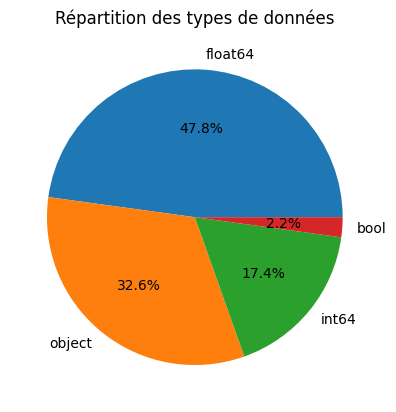

In [17]:
# Répartition du type de variable
compteur_type_variable(df_data_brut, True, True, True)

## <span style='background:green'>Nom et description des variables</span>

Voici la définition de chaque variable :

1. **OSEBuildingID**: Identifiant unique attribué à chaque propriété couverte par l'ordonnance de benchmarking de Seattle à des fins de suivi et d'identification.

2. **DataYear**: Année civile (janvier-décembre) représentée par chaque enregistrement de données.

3. **BuildingType**: Classification des types de bâtiments de la ville de Seattle.

4. **PrimaryPropertyType**: L'utilisation principale d'une propriété (par exemple, bureau, magasin de détail). L'utilisation principale est définie comme une fonction qui représente plus de 50 % d'une propriété. Il s'agit du champ "Type de Propriété" calculé par l'EPA dans le Gestionnaire de Portefeuille.

5. **PropertyName**: Nom officiel ou courant de la propriété tel qu'indiqué dans le Gestionnaire de Portefeuille de l'EPA.

6. **Address**: Adresse de la propriété.

7. **City**: Ville de la propriété.

8. **State**: État de la propriété.

9.  **ZipCode**: Code postal de la propriété.

10. **TaxParcelIdentificationNumber**: Numéro d'identification de la parcelle du comté de King de la propriété.

11. **CouncilDistrictCode**: Code du district du conseil de la ville de Seattle de la propriété.

12. **Neighborhood**: Zone de voisinage de la propriété définie par le Département des Quartiers de la Ville de Seattle.

13. **Latitude**: Latitude de la propriété.

14. **Longitude**: Longitude de la propriété.

15. **YearBuilt**: Année de construction d'une propriété ou de sa rénovation complète.

16. **NumberofBuildings**: Nombre de bâtiments inclus dans le rapport de la propriété. Dans les cas où une propriété est signalée comme un campus, plusieurs bâtiments peuvent être inclus dans un seul rapport.

17. **NumberofFloors**: Nombre d'étages déclarés auprès de Agence de la protection environnemental des USA (EPA).

18. **PropertyGFATotal**: Surface brute totale (mesurées entre les murs extérieurs) du bâtiment et du parking.

19. **PropertyGFAParking**: Espace total en pieds carrés (ft²) de tous types de stationnement (entièrement fermé, partiellement fermé et ouvert).

20. **PropertyGFABuilding(s)**: Espace total en pieds carrés (ft²) entre les surfaces extérieures des murs d'enceinte d'un bâtiment. Cela inclut toutes les zones à l'intérieur du ou des bâtiments, telles que l'espace du locataire, les espaces communs, les cages d'escalier, les sous-sols, le stockage, etc.

21. **ListOfAllPropertyUseTypes**: Toutes les utilisations de propriété rapportées auprès de l'Agence de la protection environnemental des USA (EPA).

22. **LargestPropertyUseType**: La plus grande utilisation d'une propriété (par exemple, un bureau, un magasin de détail) en termes de surface brute (GFA).

23. **LargestPropertyUseTypeGFA**: La surface brute (GFA) de la plus grande utilisation de la propriété.

24. **SecondLargestPropertyUseType**: La deuxième plus grande utilisation d'une propriété (par exemple, un bureau, un magasin de détail) en termes de surface brute (GFA).

25. **SecondLargestPropertyUseTypeGFA**: La surface brute (GFA) de la deuxième plus grande utilisation de la propriété.

26. **ThirdLargestPropertyUseType**: La troisième plus grande utilisation d'une propriété (par exemple, un bureau, un magasin de détail) en termes de surface brute (GFA).

27. **ThirdLargestPropertyUseTypeGFA**: La surface brute (GFA) de la troisième plus grande utilisation de la propriété.

28. **YearsENERGYSTARCertified**: Années où la propriété a reçu la certification ENERGY STAR.

29. **ENERGYSTARScore**: Un indice calculé par l'EPA de 1 à 100 qui évalue les performances énergétiques globales d'une propriété, basé sur des données nationales pour corriger les différences entre le climat, les utilisations des bâtiments et les opérations. Un score de 50 représente la médiane nationale.

30. **SiteEUI(kBtu/sf)**: L'intensité d'utilisation d'énergie (EUI) du site, exprimeé en kBtu/ft².

31. **SiteEUIWN(kBtu/sf)**: L'EUI sur le site normalisée par les conditions météorologiques (WN). L'utilisation d'énergie du site WN est l'utilisation d'énergie du site que la propriété aurait consommée au cours de conditions météorologiques moyennes sur 30 ans. Exprimé en kBtu/ft².

32. **SourceEUI(kBtu/sf)**: L'EUI provenant de la source d'une propriété divisée par sa surface brute. L'utilisation d'énergie provenant de la source est l'énergie annuelle utilisée pour faire fonctionner la propriété, y compris les pertes de génération, de transmission et de distribution. Exprimé en kBtu/ft².

33. **SourceEUIWN(kBtu/sf)**: L'EUI provenant de la source normalisée par les conditions météorologiques (WN). L'utilisation d'énergie provenant de la source WN est l'énergie provenant de la source que la propriété aurait consommée au cours de conditions météorologiques moyennes sur 30 ans. en kBtu/ft².

34. **SiteEnergyUse(kBtu)**: La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie. Exprimée en kBtu. 

35. **SiteEnergyUseWN(kBtu)**: La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie, ajustée à ce que la propriété aurait consommé au cours des conditions météorologiques moyennes sur 30 ans.  Exprimée en kBtu.

36. **SteamUse(kBtu)**: La quantité annuelle de vapeur de district consommée par la propriété sur place. Exprimée en kBtu.

37. **Electricity(kWh)**: La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée sur le réseau et générée par des systèmes d'énergie renouvelable sur place, exprimée en kilowattheures (kWh).

38. **Electricity(kBtu)**: La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée sur le réseau et générée par des systèmes d'énergie renouvelable sur place, exprimée en kBtu.

39. **NaturalGas(therms)**: La quantité annuelle de gaz naturel fourni par l'entreprise de services publics consommée par la propriété, mesurée en therms.

40. **NaturalGas(kBtu)**: La quantité annuelle de gaz naturel fourni par l'entreprise de services publics consommée par la propriété, mesurée en kBtu.

41. **DefaultData**: La propriété a utilisé des données par défaut pour au moins une caractéristique de la propriété. Exprimé en booléen. 

42. **Comments**: Commentaires d'un propriétaire ou d'un agent immobilier pour fournir un contexte sur l'utilisation d'énergie du bâtiment.

43. **ComplianceStatus**: Indique si une propriété a satisfait aux exigences de benchmarking énergétique pour l'année de déclaration en cours.

44. **Outlier**: Indique si une propriété est un écart élevé ou faible (O/N).

45. **TotalGHGEmissions**: La quantité totale d'émissions de gaz à effet de serre, y compris le CO2, le méthane et les gaz d'oxyde nitreux, rejetée dans l'atmosphère en raison de la consommation d'énergie de la propriété, mesurée en tonnes métriques d'équivalent de dioxyde de carbone (tCO2e). <br><br>*Ce calcul utilise un facteur d'émissions de gaz à effet de serre du portefeuille de ressources de Seattle City Light. <br>Le facteur d'émissions de CO2e de 52,44 lb/MWh de Seattle City Light jusqu'à ce que le facteur de 2016 soit disponible. <br>Le facteur de vapeur Enwave = 170,17 lb CO2e/MMBtu. <br>Le facteur de gaz est fourni par l'EPA Portfolio Manager = 53,11 kg CO2e/MBtu*.

46. **GHGEmissionsIntensity**: Les émissions totales de gaz à effet de serre divisées par la superficie brute de la propriété, mesurée en kg CO2e/ft². <br><br>*Ce calcul utilise un facteur d'émissions de gaz à effet de serre du portefeuille de ressources de Seattle City Light.*

*Rappel conversion unitées Anglo-Saxonne / Internationales:*
 
1 ft (pied) = 0,305 m<br>
1 m = 3,281 ft

1 ft² = 0,093 m²<br>
1 m² = 10,764 ft²

1 kBtu (kilobritish thermal units) = 0,293 kWh<br>
1 kWh = 3,412 kBtu

1 therm (conso de gaz) = 100 kBtu = 29,3 kWh<br>

1 lb (livre) = 0,454 kg<br>
1 kg = 2,205 lb (livre)

facteur d'émissions de CO2e (Seattle City Light/2015) = 52,44 lb/MWh = 23,78 kg/MWh (kg/mégawattheure)<br>
Le facteur de vapeur Enwave = 170,17 lb CO2e/MMBtu = 77,257 kg CO2e/MMBtu = 0,263 kg CO2e/kWh
<br><br>

*Rappel Acronymes administratifs:*

**GFA** = Gross Floor Area = Surface hors oeuvre brute : somme des surfaces de chaque niveau, des surfaces des toitures-terrasses, des balcons ou loggias et des surfaces non closes situées au rez-de-chaussée, y compris l’épaisseur des murs et des cloisons. 

**EPA** = Environmental Protection Agency = Agence de la protection environnemental des USA : agence qui a lancé le programme 'Energy STAR' en 1992.

**EUI** = Energy Use Intensity = Intensité d'utilisation d'énergie : mesure qui permet d'évaluer l'efficacité énergétique d'un bâtiment ou d'une propriété. Elle est calculée avec l'utilisation d'énergie du site d'une propriété divisée par sa surface brute. L'utilisation d'énergie du site est la quantité annuelle de toute l'énergie consommée par la propriété sur place, telle que rapportée sur les factures d'utilité. L'EUI du site est mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré, soit en kBtu/pied².

## <span style='background:green'>Résumé des données</span>

Quantitatives

In [18]:
# Résumé des variables quantitatives
df_data_brut.describe(exclude=[np.object_])

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.00000,3376.0,3360.00000,3376.00000,3376.00000,3376.00000,3376.00000,3368.00000,3376.00000,3.37600e+03,3376.00000,3.37600e+03,3.35600e+03,1679.00000,596.00000,2533.00000,3369.00000,3370.00000,3367.00000,3367.00000,3.37100e+03,3.37000e+03,3.36700e+03,3.36700e+03,3.36700e+03,3.36700e+03,3.36700e+03,3376,0.0,3367.00000,3367.00000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3263,NaN,NaN,NaN
mean,21208.99111,2016.0,98116.94911,4.43928,47.62403,-122.33480,1968.57316,1.10689,4.70912,9.48335e+04,8001.52607,8.68320e+04,7.91776e+04,28444.07582,11738.67517,67.91867,54.73212,57.03380,134.23285,137.78393,5.40367e+06,5.27673e+06,2.74596e+05,1.08664e+06,3.70761e+06,1.36850e+04,1.36850e+06,NaN,NaN,119.72397,1.17592
std,12223.75701,0.0,18.61520,2.12063,0.04776,0.02720,33.08816,2.10840,5.49446,2.18838e+05,32326.72393,2.07940e+05,2.01703e+05,54392.91793,29331.19929,26.87327,56.27312,57.16333,139.28755,139.10981,2.16106e+07,1.59388e+07,3.91217e+06,4.35248e+06,1.48507e+07,6.70978e+04,6.70978e+06,NaN,NaN,538.83223,1.82145
min,1.00000,2016.0,98006.00000,1.00000,47.49917,-122.41425,1900.00000,0.00000,0.00000,1.12850e+04,0.00000,3.63600e+03,5.65600e+03,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,-2.10000,0.00000e+00,0.00000e+00,0.00000e+00,-3.38268e+04,-1.15417e+05,0.00000e+00,0.00000e+00,NaN,NaN,-0.80000,-0.02000
25%,19990.75000,2016.0,98105.00000,3.00000,47.59986,-122.35066,1948.00000,1.00000,2.00000,2.84870e+04,0.00000,2.77560e+04,2.50948e+04,5000.00000,2239.00000,53.00000,27.90000,29.40000,74.70000,78.40000,9.25129e+05,9.70182e+05,0.00000e+00,1.87423e+05,6.39487e+05,0.00000e+00,0.00000e+00,NaN,NaN,9.49500,0.21000
50%,23112.00000,2016.0,98115.00000,4.00000,47.61867,-122.33249,1975.00000,1.00000,4.00000,4.41750e+04,0.00000,4.32160e+04,3.98940e+04,10664.00000,5043.00000,75.00000,38.60000,40.90000,96.20000,101.10000,1.80375e+06,1.90445e+06,0.00000e+00,3.45130e+05,1.17758e+06,3.23754e+03,3.23754e+05,NaN,NaN,33.92000,0.61000
75%,25994.25000,2016.0,98122.00000,7.00000,47.65712,-122.31941,1997.00000,1.00000,5.00000,9.09920e+04,0.00000,8.42762e+04,7.62002e+04,26640.00000,10138.75000,90.00000,60.40000,64.27500,143.89999,148.35000,4.22246e+06,4.38143e+06,0.00000e+00,8.29318e+05,2.82963e+06,1.18903e+04,1.18903e+06,NaN,NaN,93.94000,1.37000


Qualitatives

In [19]:
# Résumé des variables qualitatives
df_data_brut.describe(exclude=[np.number])

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier
count,3376,3376,3376,3376,3376,3376,3376,3376,3367,3356,1679,596,119,3376,3376,32
unique,8,24,3362,3354,1,1,3268,19,466,56,50,44,65,2,4,2
top,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,1625049001,DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,2016,False,Compliant,Low outlier
freq,1460,987,3,4,3376,3376,8,573,866,1667,976,110,14,3263,3211,23


## <span style='background:green'>Valeurs manquantes</span>

Valeurs manquantes (Nan) : 19952 / 155296 données (12.85 %)
26 / 46 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
SiteEnergyUse(kBtu),5,0.150000
SiteEUIWN(kBtu/sf),6,0.180000
SiteEnergyUseWN(kBtu),6,0.180000
SiteEUI(kBtu/sf),7,0.210000
NumberofBuildings,8,0.240000
NaturalGas(kBtu),9,0.270000
NaturalGas(therms),9,0.270000
Electricity(kBtu),9,0.270000
Electricity(kWh),9,0.270000
SteamUse(kBtu),9,0.270000


26 / 46 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


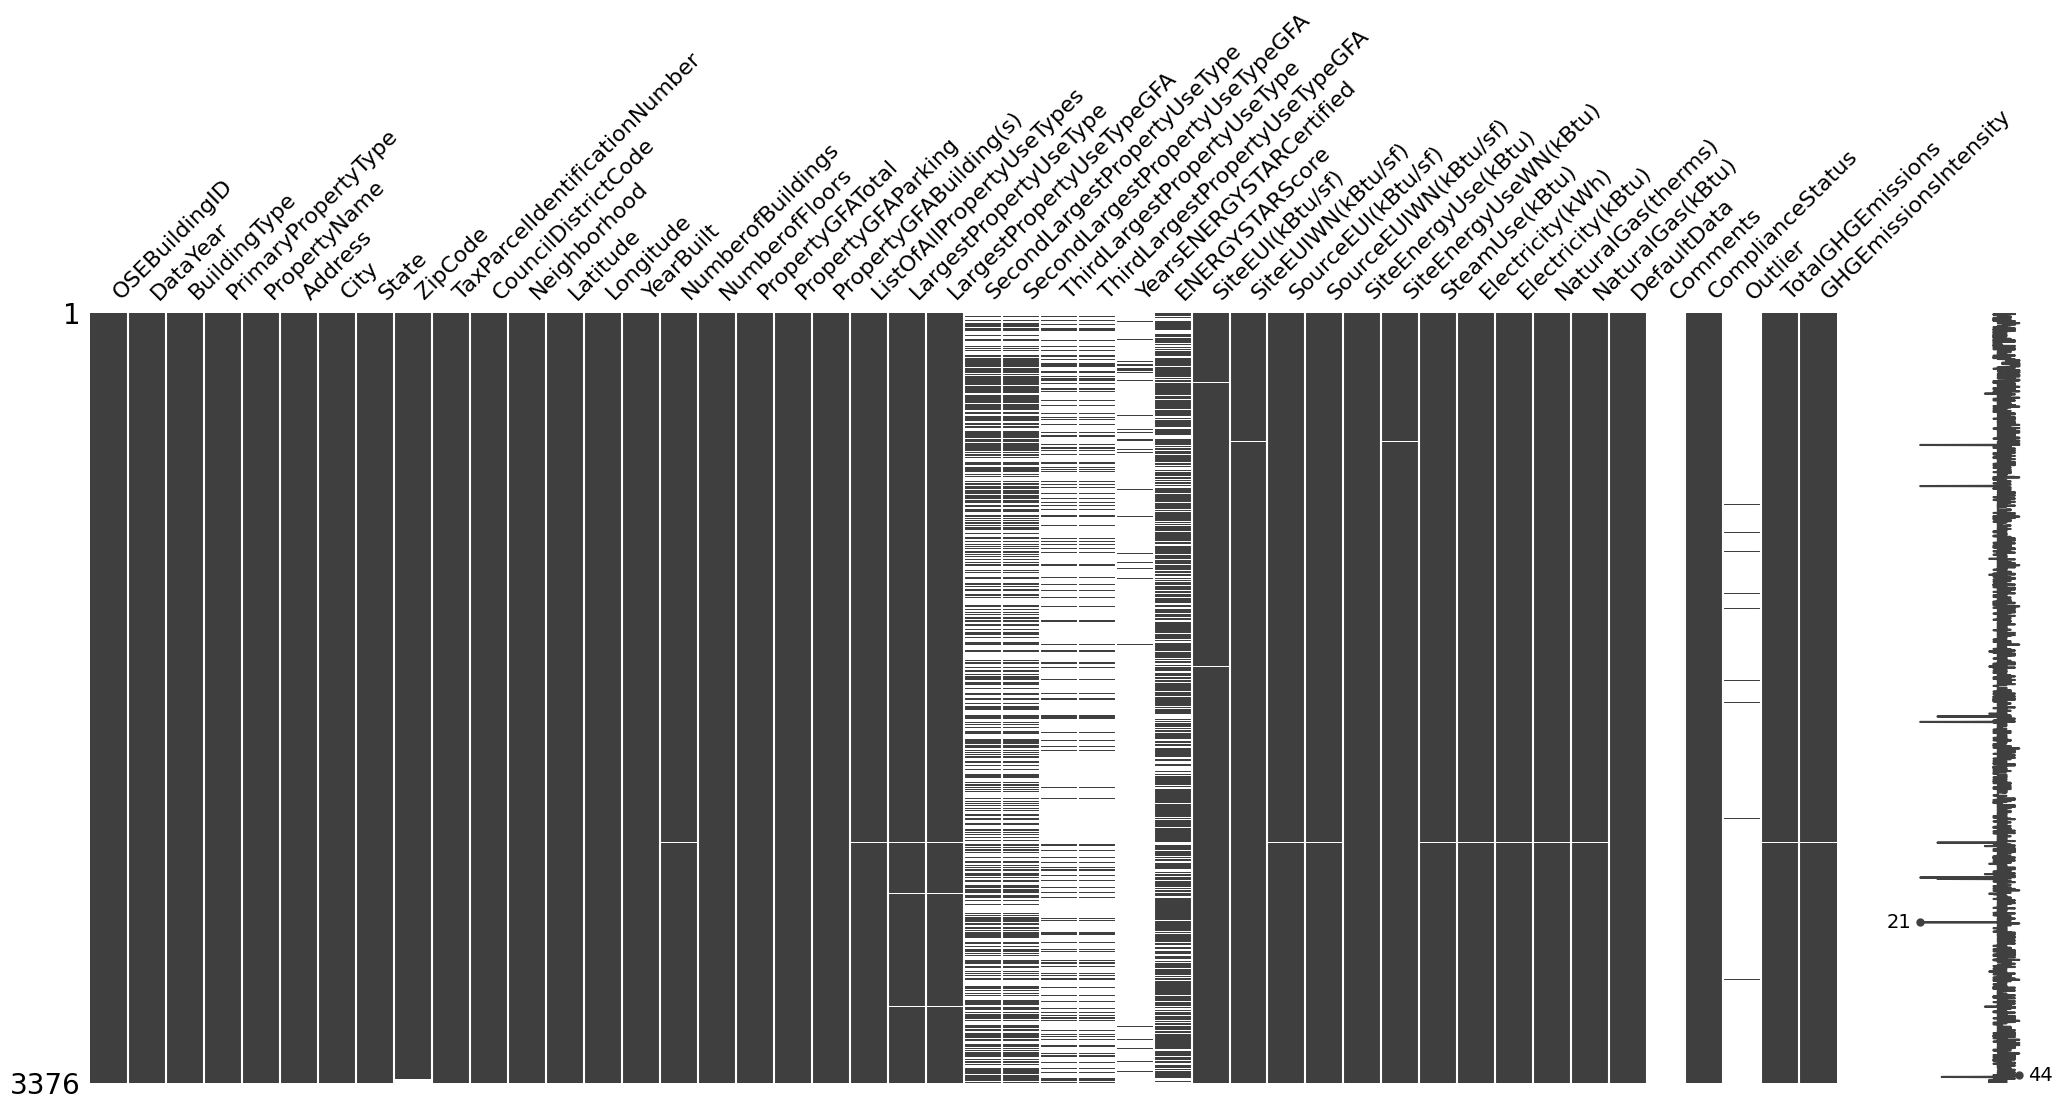

In [20]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_brut, True, True)

## <span style='background:green'>Doublons</span>

In [21]:
# Detection des doublons sur la variable du code
first = detect_doublon(df_data_brut, 'OSEBuildingID', 'first')

Doublons détecté(s) avec "first" sur "OSEBuildingID" : 0


___
**Bilan sur le jeu de données '2016_Building_Energy_Benchmarking.csv'**: 
___
-   Le jeu de données contient **3_376 lignes et 46 colonnes**.
<br><br>
- Le dataset contient des informations sur les batiments : 
  - **administratif** : type de batiment, types de commerce installés 
  - **géographique** : nom et localisation du batiment, type de voisinage
  - **temporelle** : date de construction du batiment, de la mesure
  - **structurelle** : superficie (avec et sans parking), nombre de batiments séparés, nombre d'étage, superficie par commerce
  - **qualité énergétique** : ENERGY STAR Score et sa date d'obtention
  - **quantité énergétique** : quantité d'énergie, normalisé par la météo, ratio énergie/superficie, vapeur, électricié, gaz
  - **émissions** : quantité démission de gaz à effet de serre, ration émission/superficie
<br><br>
- type de données :
  - **47,8% de nombre décimaux numérique** : 
  - **32,6% de texte**
  - 17,7% d'entier numériques
  - 2,2% de booléen
<br><br>
-   valeurs manquantes : 
    -   19_952  de NaN pour 155_296  observations (**12.85 %**).
    -   26 / 46 colonnes concernées
<br><br>
-   **Pas de doublons** sur la col 'OSEBuildingID'.
<br><br><br>

# <span style='background:blue'>Etape 2 : Nettoyage des données</span>
___

## <span style='background:green'>1/ Filtrage par taux de remplissage</span>

Nous identifions les colonnes qui présentent un taux de valeurs manquantes (NaN) > 50%. 

In [22]:
# Seuil_NaN
seuil_nan = 50

# Affichage graphique des NaN
df_Nan_par_ligne, df_to_supp = filtre_nan_par_seuil(df_data_brut, seuil_nan, False)

# Affichage
print("Voici les colonnes qui vont être supprimées: ")
display(df_to_supp)

Il y a 7 colonnes > 50 % de NaN
Voici les colonnes qui vont être supprimées: 


,nombre,pourcent
SecondLargestPropertyUseTypeGFA,1697.0,50.3
SecondLargestPropertyUseType,1697.0,50.3
ThirdLargestPropertyUseTypeGFA,2780.0,82.3
ThirdLargestPropertyUseType,2780.0,82.3
YearsENERGYSTARCertified,3257.0,96.5
Outlier,3344.0,99.1
Comments,3376.0,100.0


Nous allons supprimer toutes ces features car il y a trop de valeurs manquantes pour parvenir à imputer des valeurs assez fiables. Une exception tout de même pour la feature "Outlier" qui, malgré son faible taux de remplissage, peut nous permettre d'avoir des informations intérressantes pour exclure les quelques outliers du dataset. Nous conservons cet feature. 

In [23]:
# Suppression de la ligne "Outlier" des features à effacer
df_to_supp = df_to_supp.drop("Outlier", axis=0)

# Suppression des features sélectionnées
df_data_clean_nan = df_data_brut.drop(columns=df_to_supp.index)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_nan, "df_data_clean_nan", "des nan", 2)

Voici l'aspect de 'df_data_clean_nan' après nettoyage des nan


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,1.15651e+06,3946027.0,12764.52930,1276453.0,False,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,9.50425e+05,3242851.0,51450.81641,5145082.0,False,Compliant,NaN,295.86,2.86


3376 ligne(s) x 40 colonne(s)



## <span style='background:green'>2/ Suppression colonnes redondantes</span>

### Liste des utilisation du batiment

Certaines features dans le dataset sont des features redondantes. C'est le cas par exemple de la feature qui liste les utilisations du batiment et qui est repris dans les features de chaque utilisation du batiment. 

Voici un échantillon pour preuve :

In [24]:
# Liste des colonnes sélectionnées
category_col = ["ListOfAllPropertyUseTypes","LargestPropertyUseType"]

# Afficher un échantillon (sans NaN)
df_data_clean_nan[df_data_clean_nan[category_col].notnull().any(axis=1)][category_col].sample(5)

,ListOfAllPropertyUseTypes,LargestPropertyUseType
805,Financial Office,Financial Office
2393,Multifamily Housing,Multifamily Housing
2535,"Parking, Worship Facility",Worship Facility
1629,"Multifamily Housing, Parking",Multifamily Housing
2666,Multifamily Housing,Multifamily Housing


Manifestement, la première feature comprend les élements de la deuxième mais elle en contient d'autres également. Nous vérifions le taux de remplissage de ces features :

In [25]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_nan[category_col], True, False)

Valeurs manquantes (Nan) : 29 / 6752 données (0.43 %)
2 / 2 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
ListOfAllPropertyUseTypes,9,0.270000
LargestPropertyUseType,20,0.590000


Dans le doute, nous allons garder ces features en l'état car nous ne savons pas laquelle possèdent le plus d'information pertinente. 

### Quantité d'énergie

Certaines features dans le dataset sont des features redondantes. C'est le cas par exemple des features qui indiquent la quantité d'énergie dasn différentes unités. 

Voici un échantillon pour preuve :

In [26]:
# Liste des colonnes sélectionnées
category_col = ["Electricity(kWh)", "Electricity(kBtu)", "NaturalGas(therms)", "NaturalGas(kBtu)"]

# Afficher le début (sans NaN)
df_data_clean_nan[df_data_clean_nan[category_col].notnull().any(axis=1)][category_col].head(3)

,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu)
0,1.15651e+06,3946027.0,12764.52930,1276453.0
1,9.50425e+05,3242851.0,51450.81641,5145082.0
2,1.45154e+07,49526664.0,14938.00000,1493800.0


Sachant que:<br>
1 kBtu = 0,293 kWh => ALORS 3_946_027 kBtu = 1_156_185 kWh<br>
**Donc le feature "Electricity(kBtu)" semble juste une conversion de la feature "Electricity(kWh)"**

Sachant que:<br>
1 therm = 100 kBtu => ALORS 12_764.52 therm = 1_276_452 kWh<br>
**Donc le feature "NaturalGas(kBtu)" semble juste une conversion de la feature "NaturalGas(therms)"**

Si nous regardons le taux de remplissage de ces 4 features, nous pouvons constater qu'elles sont toutes les 4 remplies de façon similaire. Ce qui suppose que chacune d'elle contiennent les mêmes données, qui sont donc redondantes.

In [27]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_nan[category_col], True, False)

Valeurs manquantes (Nan) : 36 / 13504 données (0.27 %)
4 / 4 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
Electricity(kWh),9,0.270000
Electricity(kBtu),9,0.270000
NaturalGas(therms),9,0.270000
NaturalGas(kBtu),9,0.270000



Dans un soucis d'harmonisation des unités de quantité d'énergie du dataset (en kBtu), nous supprimons les colonnes qui ne sont pas en kBtu.

In [28]:
# Suppression des features redondantes
df_data_clean_redondant = df_data_clean_nan.drop(columns=["Electricity(kWh)", "NaturalGas(therms)"])

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_redondant, "df_data_clean_redondant", "des features redondantes", 2)

Voici l'aspect de 'df_data_clean_redondant' après nettoyage des features redondantes


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,False,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,False,Compliant,NaN,295.86,2.86


3376 ligne(s) x 38 colonne(s)



## <span style='background:green'>3/ Suppression colonnes inutiles</span>

### Année de mesure, Ville, code postal et état

Nous remarquons que 3 features ne présentent chacun qu'une seule valeur avec la totalité du dataset

In [29]:
# Résumé d'une variable quantitative
df_data_clean_redondant[["DataYear"]].describe()

,DataYear
count,3376.0
mean,2016.0
std,0.0
min,2016.0
25%,2016.0
50%,2016.0
75%,2016.0
max,2016.0


In [30]:
# Résumé de variables qualitatives
df_data_clean_redondant[["City", "State"]].describe()

,City,State
count,3376,3376
unique,1,1
top,Seattle,WA
freq,3376,3376


Il n'est donc pas utile de garder ces features. Il suffit de se rappeler que tous les batiements sont dans la ville de Seattle dans l'état de Washington. Le code postal est également inutile pour la suite des traitements. Nous pouvons supprimer ces features. 

In [31]:
# Liste des features inutiles à supprimer
col_to_supp = ["DataYear", "City", "State", "ZipCode"]

# Suppression des features inutiles
df_data_clean_inutile = df_data_clean_redondant.drop(columns=col_to_supp)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_inutile, "df_data_clean_inutile", "des features inutiles", 2)

Voici l'aspect de 'df_data_clean_inutile' après nettoyage des features inutiles


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,False,Compliant,NaN,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,False,Compliant,NaN,295.86,2.86


3376 ligne(s) x 34 colonne(s)



## <span style='background:green'>4/ Conservation des batiments non destinés à l'habitation</span>

Notre mission ne concerne que les **bâtiments non destinés à l’habitation de la ville de Seattle**. Nous allons donc supprimer toutes les lignes qui sont des habitations dans la feature "BuildingType". 

Visualisons toutes les valeurs possible de cet feature :

In [32]:
df_data_clean_inutile['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

Nous détectons 3 types de batiment qui sont destinées à l'habitation :
- 'Multifamily MR (5-9)'
- 'Multifamily LR (1-4)'
- 'Multifamily HR (10+)'

Nous supprimons les lignes de ces habitation 'Multifamily'. 

In [33]:
# Filtrage batiment non habitation
df_data_clean_habitation = df_data_clean_inutile[~df_data_clean_inutile['BuildingType'].str.contains("Multifamily")]

# Valeurs restantes de "BuildingType"
df_data_clean_habitation['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

Nous avons bien conservé uniquement les batiments non destinés à l'habitation.

In [34]:
# Mise à jour des index
df_data_clean_habitation.reset_index(drop=True, inplace=True)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_habitation, "df_data_clean_habitation", "des habitations", 2)

Voici l'aspect de 'df_data_clean_habitation' après nettoyage des habitations


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,False,Compliant,NaN,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,False,Compliant,NaN,295.86,2.86


1668 ligne(s) x 34 colonne(s)



## <span style='background:green'>4/ Conservation des batiments non recencés en outlier</span>

La feature "outlier' nous indique les batiments qui peuvent être utile d'exclure pour éviter que leurs valeurs atypiques affectent nos calculs à venir. 

Visualisons toutes les valeurs possible de cet feature :

In [35]:
# Dataframe des lignes non nulle sur la feature "Outlier"
df_outlier_all = df_data_clean_habitation[df_data_clean_habitation["Outlier"].notnull()]

# Afficher les valeurs possibles
outlier_unique = df_outlier_all["Outlier"].unique()
display(outlier_unique)

# Affichage aperçu et dimension du dataframe
display(df_outlier_all)
print_nbr_ligne_col(df_outlier_all)

array(['High outlier', 'Low outlier'], dtype=object)

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
220,350,NonResidential,Large Office,Second And Spring Building,1100 Second Avenue,0942000045,7,DOWNTOWN,47.60642,-122.33581,1958,1.0,6,172842,25920,146922,"Data Center, Office, Parking",Office,99890.0,NaN,297.39999,299.20001,909.59998,911.50000,4.13995e+07,4.16504e+07,0.0,39794668.0,1604831.0,False,Non-Compliant,High outlier,362.66,2.10
378,539,NonResidential,Retail Store,University Center,4501 Roosevelt Way NE,5335200380,4,NORTHEAST,47.66178,-122.31812,1987,1.0,2,69492,0,69492,Retail Store,Retail Store,69800.0,100.0,4.60000,4.60000,14.30000,14.30000,3.18963e+05,3.18963e+05,0.0,318963.0,0.0,False,Non-Compliant,Low outlier,2.22,0.03
442,608,NonResidential,Large Office,411 1ST AVE S (ID608),411 1ST AVE S,5247800200,2,DOWNTOWN,47.59878,-122.33458,1913,5.0,7,154159,0,154159,Office,Office,193154.0,100.0,58.00000,58.80000,28.00000,28.70000,1.11959e+07,1.13488e+07,0.0,1608768.0,343050.0,False,Non-Compliant,Low outlier,29.43,0.19
507,704,NonResidential,Large Office,401 Elliott Ave West,401 Elliot Ave West,7666202110,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,1.0,4,129551,42500,87051,"Data Center, Office, Parking",Office,82273.0,1.0,311.70001,311.70001,978.90002,978.90002,2.71372e+07,2.71372e+07,0.0,27137187.0,0.0,False,Non-Compliant,High outlier,189.18,1.46
698,19967,SPS-District K-12,K-12 School,Queen Anne Gym,1431 2nd Ave N,0811000005,7,MAGNOLIA / QUEEN ANNE,47.63203,-122.35337,2001,1.0,1,35805,0,35805,K-12 School,K-12 School,35805.0,100.0,12.10000,12.10000,27.00000,27.00000,4.31472e+05,4.31472e+05,0.0,246628.0,184844.0,True,Error - Correct Default Data,Low outlier,11.54,0.32
777,20617,NonResidential,Retail Store,Seattle Habitat Store,21 S Nevada St,1824049074,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1.0,1,39900,0,39900,"Non-Refrigerated Warehouse, Retail Store",Retail Store,25000.0,100.0,3.60000,3.60000,6.40000,6.40000,1.45469e+05,1.45469e+05,0.0,49005.0,96464.0,True,Error - Correct Default Data,Low outlier,5.46,0.14
868,21315,NonResidential,Small- and Mid-Sized Office,1518 Fifith Ave,1520 Fifth Ave,1975700135,7,DOWNTOWN,47.61119,-122.33581,1903,1.0,3,57720,0,57720,Office,Office,25000.0,NaN,1.00000,1.00000,3.00000,3.00000,2.41055e+04,2.41055e+04,0.0,24105.0,0.0,False,Non-Compliant,Low outlier,0.17,0.00
910,21474,NonResidential,Other,The Lusty Lady,1315 1st Ave,1976200060,7,DOWNTOWN,47.60711,-122.33886,1900,1.0,3,49760,0,49760,Other,Other,24019.0,NaN,1.80000,1.80000,5.80000,5.80000,4.42935e+04,4.42935e+04,0.0,44294.0,0.0,False,Non-Compliant,Low outlier,0.31,0.01
1033,22830,NonResidential,Worship Facility,Freedom Church,9601 35th Ave,2858600090,1,SOUTHWEST,47.51709,-122.37797,1971,1.0,1,23772,0,23772,Worship Facility,Worship Facility,23772.0,100.0,4.20000,4.20000,13.30000,13.30000,1.00842e+05,1.00842e+05,0.0,100842.0,0.0,False,Non-Compliant,Low outlier,0.70,0.03
1134,23912,NonResidential,Small- and Mid-Sized Office,1416 S Jackson,1416 South Jackson Street,3320000165,3,CENTRAL,47.59973,-122.31331,1947,1.0,1,45068,0,45068,Office,Office,45068.0,100.0,6.30000,6.90000,13.20000,13.80000,2.84857e+05,3.09214e+05,0.0,141784.0,143073.0,False,Non-Compliant,Low outlier,8.59,0.19


17 ligne(s) x 34 colonne(s)



Nous supprimons ces batiments qui sont spécifiés comme étant des outliers

In [36]:
# Filtrage batiment outlier
df_data_clean_outlier = df_data_clean_habitation[~df_data_clean_habitation['Outlier'].isin(outlier_unique)]

L'information contenue dans la feature "Outlier" ayant été traitée, nous supprimons cet feature qui est faiblement remplie.

In [37]:
# Suppression des features inutiles
df_data_clean_outlier = df_data_clean_outlier.drop(columns=["Outlier"])

# Mise à jour des index
df_data_clean_outlier.reset_index(drop=True, inplace=True)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_outlier, "df_data_clean_outlier", "des outliers", 2)

Voici l'aspect de 'df_data_clean_outlier' après nettoyage des outliers


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,False,Compliant,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,False,Compliant,295.86,2.86


1651 ligne(s) x 33 colonne(s)



## <span style='background:green'>5/ Filtrage des batiments par taux de remplissage > 50%</span>

Nous identifions les lignes des batiments qui présentent > 50% de valeurs manquantes. 

In [38]:
# Comptage du nombre de feature quantitatives
feat_quanti_list = df_data_clean_outlier.select_dtypes(include=['int', 'float']).columns
feat_quanti_nb = len(feat_quanti_list)

# Définissez le seuil pour le % de NaN
seuil_valeur = 0.50
seuil_nb_feat = seuil_valeur * feat_quanti_nb

# Somme des NaN par ligne
nan_par_ligne_nb = df_data_clean_outlier.isna().sum(axis=1)

# Sélection et affichage des ligne au dessus du seuil
ligne_to_suppr = df_data_clean_outlier[nan_par_ligne_nb >= seuil_nb_feat]

print("Il y a {} features quantitatives, donc le seuil de {:.0f} % de NaN correspond à {:.0f} features minimum par ligne de batiment. Voici les lignes de batiment qui ne remplissent pas cette condition :".format(feat_quanti_nb, seuil_valeur * 100, seuil_nb_feat))
display(ligne_to_suppr)

Il y a 23 features quantitatives, donc le seuil de 50 % de NaN correspond à 12 features minimum par ligne de batiment. Voici les lignes de batiment qui ne remplissent pas cette condition :


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
564,773,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,215 COLUMBIA ST,0939000245,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN
1408,26532,NonResidential,Mixed Use Property,KALBERG BUILDING,4515 UNIVERSITY WAY NE,8816401120,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN


Nous supprimons ces lignes de batiment avec > 50% de NaN dans les features quantitatives.

In [39]:
# Utilisez la méthode isin pour créer un masque (mask) des lignes à supprimer
masque = df_data_clean_outlier.isin(ligne_to_suppr.to_dict(orient='list')).all(axis=1)

# Appliquez le masque pour sélectionner les lignes à conserver
df_data_clean_batiment_nan = df_data_clean_outlier[~masque]

# Mise à jour des index
df_data_clean_batiment_nan.reset_index(drop=True, inplace=True)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_batiment_nan, "df_data_clean_batiment_nan", "des batiments avec >50% de caleurs manquantes", 2)

Voici l'aspect de 'df_data_clean_batiment_nan' après nettoyage des batiments avec >50% de caleurs manquantes


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,False,Compliant,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,False,Compliant,295.86,2.86


1649 ligne(s) x 33 colonne(s)



## <span style='background:green'>6/ Imputation variable qualitative</span>

Le dataframe actuel ne comporte plus beaucoup de valeurs manquantes.

In [40]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_batiment_nan, True, False)

Valeurs manquantes (Nan) : 577 / 54417 données (1.06 %)
6 / 33 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
SiteEUI(kBtu/sf),1,0.060000
SiteEUIWN(kBtu/sf),1,0.060000
SiteEnergyUseWN(kBtu),1,0.060000
LargestPropertyUseType,4,0.240000
LargestPropertyUseTypeGFA,4,0.240000
ENERGYSTARScore,566,34.320000


Nous remarquons qu'il n'y a que la feature "ENERGYSTARScore" pour laquelle de nombreuses lignes de batiment présentent des valeurs manquantes. 

Affichons le type de donnée des lignes de batiment qui présentent une valeur manquante sur d'autres features.

Puis affichons les lignes concernées par ces NaN. 

In [41]:
# Liste des features avec des Nan (hors "ENERGYSTARScore")
feature_nan_list = ["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SiteEnergyUseWN(kBtu)", "LargestPropertyUseType", "LargestPropertyUseTypeGFA"]

# Répartition du type de variable
compteur_type_variable(df_data_clean_batiment_nan[feature_nan_list], True, False, False)

# Affichage NaN (sans prendre en compte "ENERGYSTARScore")
lignes_avec_nan = affiche_nan_hors_energyscore(df_data_clean_batiment_nan, feature_nan_list)

----------------------------------------------------------------------------------------------------
Type de variable pour chacune des variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SiteEUI(kBtu/sf)           1648 non-null   float64
 1   SiteEUIWN(kBtu/sf)         1648 non-null   float64
 2   SiteEnergyUseWN(kBtu)      1648 non-null   float64
 3   LargestPropertyUseType     1645 non-null   object 
 4   LargestPropertyUseTypeGFA  1645 non-null   float64
dtypes: float64(4), object(1)
memory usage: 64.5+ KB


None

 Voici 6 les lignes de batiment qui présentent des Nan, hors feature 'ENERGYSTARScore' :


,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),LargestPropertyUseType,LargestPropertyUseTypeGFA
297,NaN,0.0,0.00000e+00,Convention Center,1072000.0
346,47.8,51.0,6.07696e+06,NaN,NaN
549,39.5,NaN,NaN,Office,120248.0
814,52.2,53.5,2.96843e+06,NaN,NaN
1335,72.2,74.7,3.28096e+06,NaN,NaN
1352,31.2,32.5,9.35833e+05,NaN,NaN


Nous remarquons que seul la feature "LargestPropertyUseType" contient des données qualitatives. Nous avons vu précedement que la feature "ListOfAllPropertyUseTypes" présente les valeurs des 3 features de la famille de "LargestPropertyUseType".  

Affichons les valeurs de ces 2 features à l'endroit où il y a des NaN :

In [42]:
# Liste des features avec des Nan (hors "ENERGYSTARScore")
feature_usetype_list = ["ListOfAllPropertyUseTypes", "LargestPropertyUseType"]

# Création masque pour identifier les lignes avec NaN (hors feature spécifiée)
masque_nan = df_data_clean_batiment_nan[feature_usetype_list].isna().any(axis=1)

# Appliquez le masque pour filtrer les lignes
lignes_nan_usetype = df_data_clean_batiment_nan[masque_nan]

# Affichez les lignes avec NaN dans la colonne 'LargestPropertyUseType'
display(lignes_nan_usetype[feature_usetype_list])

,ListOfAllPropertyUseTypes,LargestPropertyUseType
346,"Fitness Center/Health Club/Gym, Office, Other ...",NaN
814,Hotel,NaN
1335,Office,NaN
1352,Restaurant,NaN


Nous pouvons implémenter les valeurs manquantes de la feature "LargestPropertyUseType" avec celle de la feature "ListOfAllPropertyUseTypes" puisqu'il n'y a qu'une seule valeur. A l'exception de la ligne 346 car il n'y a pas qu'une seule valeur (nous la supprimons). 

In [43]:
# Copie du dataframe
df_data_clean_usetype_nan = df_data_clean_batiment_nan.copy()

# Suppression de la ligne 346
df_data_clean_usetype_nan.drop(346, inplace=True)

# Mise à jour des index
df_data_clean_usetype_nan.reset_index(drop=True, inplace=True)

# Remplacez NaN de 'LargestPropertyUseType' par valeur 'ListOfAllPropertyUseTypes'
df_data_clean_usetype_nan['LargestPropertyUseType'].fillna(df_data_clean_usetype_nan['ListOfAllPropertyUseTypes'], inplace=True)

Nous affichons à nouveau les lignes qui étaient concernées par les NaN (sauf "ENERGYSTARScore"). 

In [44]:
# Affichage NaN (sans prendre en compte "ENERGYSTARScore")
lignes_avec_nan = affiche_nan_hors_energyscore(df_data_clean_usetype_nan, feature_nan_list)

 Voici 5 les lignes de batiment qui présentent des Nan, hors feature 'ENERGYSTARScore' :


,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),LargestPropertyUseType,LargestPropertyUseTypeGFA
297,NaN,0.0,0.00000e+00,Convention Center,1072000.0
548,39.5,NaN,NaN,Office,120248.0
813,52.2,53.5,2.96843e+06,Hotel,NaN
1334,72.2,74.7,3.28096e+06,Office,NaN
1351,31.2,32.5,9.35833e+05,Restaurant,NaN


Nous remarquons que la feature "LargestPropertyUseType" est bien remplie. Nous pouvons supprimer cet feature de la liste des features présentant des Nan.

In [45]:
# Enlevez 'LargestPropertyUseType' de la liste
feature_nan_list.remove("LargestPropertyUseType")

# Affichez la liste mise à jour
print(feature_nan_list)

['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'LargestPropertyUseTypeGFA']



Les NaN restantes ne concernent plus que des données quantitatives. 

In [46]:
# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_usetype_nan, "df_data_clean_usetype_nan", "des Nan des features qualitatifs", 2)

Voici l'aspect de 'df_data_clean_usetype_nan' après nettoyage des Nan des features qualitatifs


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,False,Compliant,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,False,Compliant,295.86,2.86


1648 ligne(s) x 33 colonne(s)



## <span style='background:green'>7/ Imputation des données quantitatives</span>

Le dataframe ne comporte des NaN plus que sur des valeurs quantitatives.

In [47]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_usetype_nan, True, False)

Valeurs manquantes (Nan) : 571 / 54384 données (1.05 %)
5 / 33 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
SiteEUI(kBtu/sf),1,0.060000
SiteEUIWN(kBtu/sf),1,0.060000
SiteEnergyUseWN(kBtu),1,0.060000
LargestPropertyUseTypeGFA,3,0.180000
ENERGYSTARScore,565,34.280000


Nous isolons les features quantitatives dans un dataframe de travail pour l'imputation. 

In [48]:
# Comptage du nombre de feature quantitatives
feat_quanti_list = df_data_clean_usetype_nan.select_dtypes(include=['int', 'float']).columns

# df de travail est une copie des features d'energie du dataframe des données
df_travail = df_data_clean_usetype_nan[feat_quanti_list]

# Affichage dataframe des données quantitatives
display(df_travail.head(3))
print(df_travail.shape)

,OSEBuildingID,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,7,47.61220,-122.33799,1927,1.0,12,88434,0,88434,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,249.98,2.83
1,2,7,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,295.86,2.86
2,3,7,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,756493.0,43.0,96.0,97.7,241.89999,244.10001,72587024.0,73937112.0,21566554.0,49526664.0,1493800.0,2089.28,2.19


(1648, 23)


### Energie

Nous allons implémenter les NaN des features concernant des valeurs d'energie par des calculs de machine learning en utilisant l'algorithme KNN. 

Nous allons d'abord observer la distribution et les statitisques descriptives des colonnes avant l'imputation.

['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)'] 



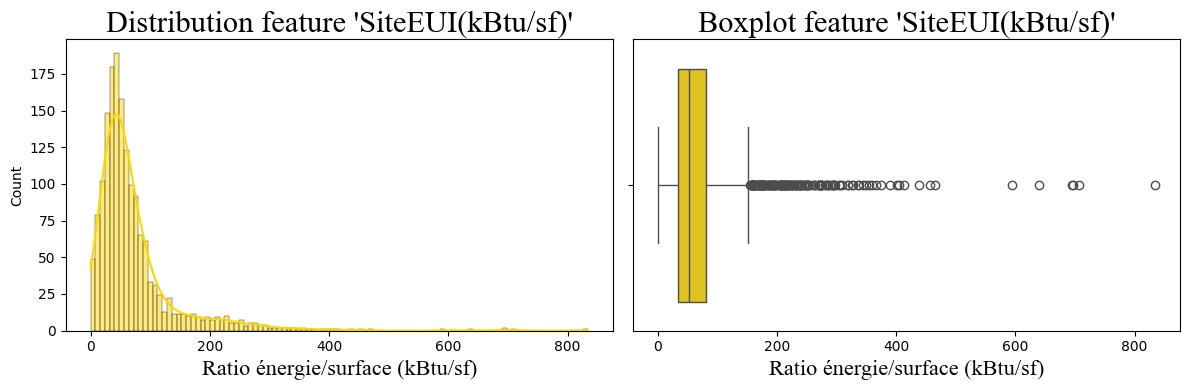

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,34.0,72.5,52.1,81.8,73.7,1.02,3.77,22.7


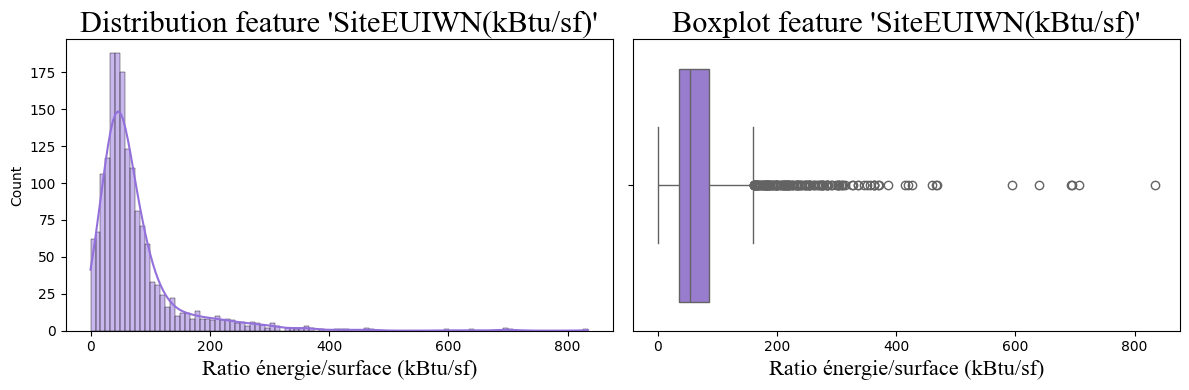

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,36.0,74.9,54.3,85.6,74.7,1.0,3.67,21.5


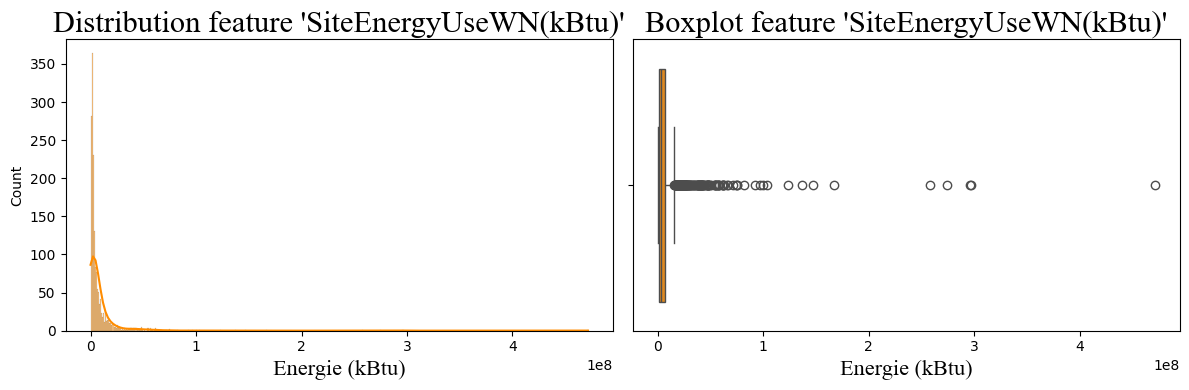

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,1319331.9,8099006.3,2726126.8,7172461.8,22119613.4,2.73,11.28,177.4


In [49]:
# Liste des features d'energie
energy_all_list = [
    "SiteEUI(kBtu/sf)", 
    "SiteEUIWN(kBtu/sf)", 
    "SourceEUI(kBtu/sf)",
    "SourceEUIWN(kBtu/sf)",
    "SiteEnergyUse(kBtu)",
    "SiteEnergyUseWN(kBtu)",
    "SteamUse(kBtu)",
    "Electricity(kBtu)",
    "NaturalGas(kBtu)"]

# Listes des features d'energie avec Nan
energy_nan_list = feature_nan_list[0:3]
print(energy_nan_list, "\n")

# POUR chaque feature d'energie avec NaN
for idx, col in enumerate(energy_nan_list): 
    
    # Courbe (axe des X adapté à chaque feature)
    if "sf" in col[-5:]:
        plot_distribution(df_travail, col, colors_list[idx], unit="Ratio énergie/surface (kBtu/sf)")
    else:
        plot_distribution(df_travail, col, colors_list[idx], unit="Energie (kBtu)")
    
    # Calcul des stats descriptives
    df_stat = stats_descriptives(df_travail, col)
    display(df_stat)

Nous allons utiliser l'imputation par le KNNImputer.

Nous allons d'abord utiliser un GridSearch pour calculer le nombre de voisin optimal pour l'imputation KNN

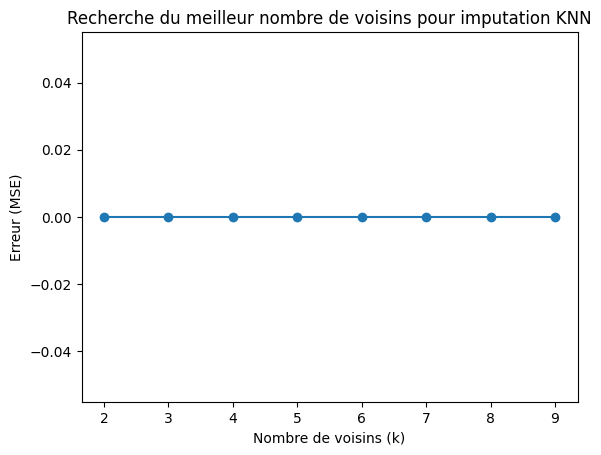

Le meilleur nombre de voisins est : 2


In [50]:
# Bornes du GridSearch
k_min, k_max = 2, 10

# Calcul du meilleur nombre de voisin pour l'imputation KNN
errors = determine_meilleur_voisin_knn(df_travail[energy_all_list], k_min, k_max)

Nous réalisons donc l'imputation KNN avec le nombre optimal de voisin trouvés : 2

In [51]:
# Créez un objet d'imputation KNN (2 voisins proches, valeurs manquantes=NaN)
imputerKNN = KNNImputer(n_neighbors=2, missing_values=np.nan)

# Entraînez et applique le modèle d'imputation KNN 
df_datas_imputed = pd.DataFrame(imputerKNN.fit_transform(df_travail[energy_all_list]), columns=df_travail[energy_all_list].columns)

Nous allons vérifier la distribution et les statitisques descriptives des colonnes après l'imputation.

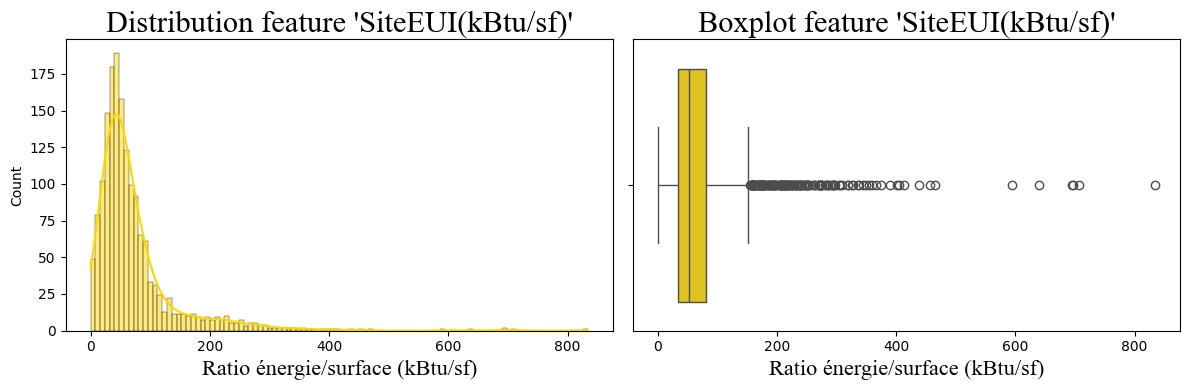

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,34.0,72.4,52.1,81.7,73.7,1.02,3.77,22.7


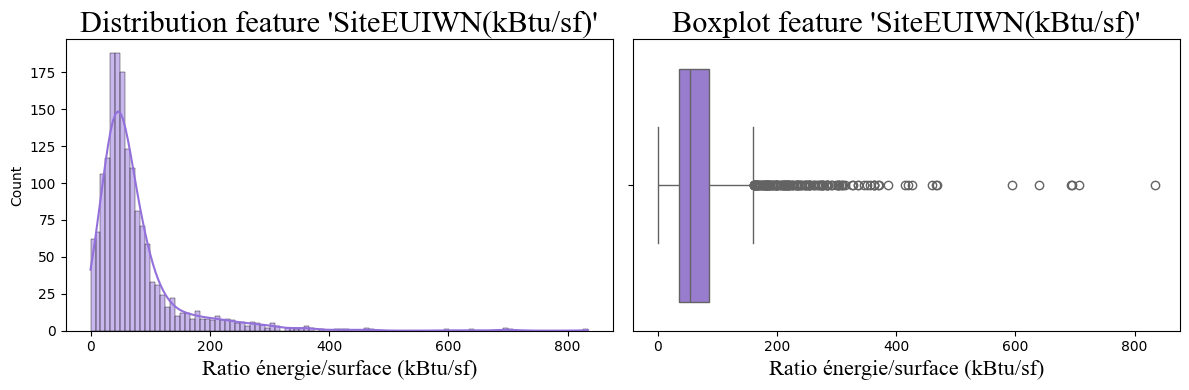

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,36.1,74.9,54.3,85.7,74.7,1.0,3.67,21.5


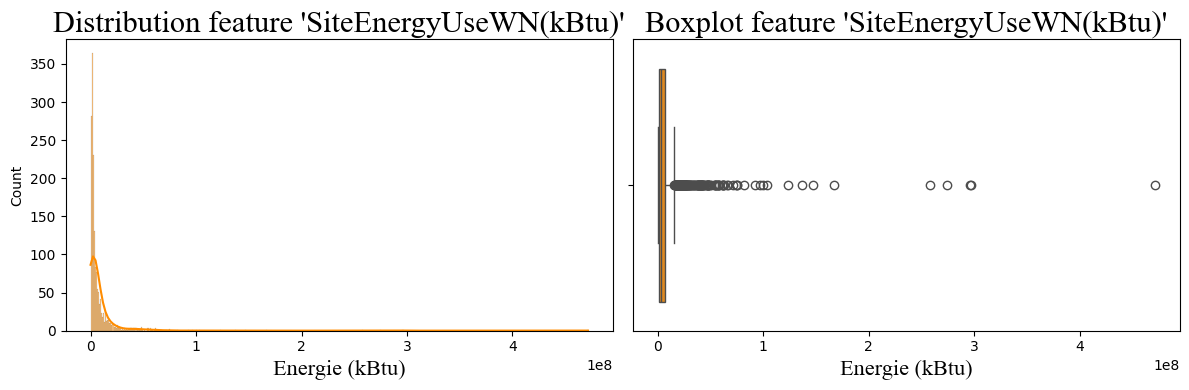

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,1320547.5,8097373.2,2730646.4,7167892.6,22113000.6,2.73,11.29,177.5


In [52]:
# POUR chaque feature d'energie avec NaN
for idx, col in enumerate(energy_nan_list): 
    
    # Courbe (axe des X adapté à chaque feature)
    if "sf" in col[-5:]:
        plot_distribution(df_travail, col, colors_list[idx], unit="Ratio énergie/surface (kBtu/sf)")
    else:
        plot_distribution(df_travail, col, colors_list[idx], unit="Energie (kBtu)")
    
    # Calcul des stats descriptives
    df_stat = stats_descriptives(df_datas_imputed, col)
    display(df_stat)

La distribution des données d'énergie qui présentaient des NaN ont été bien conservées suite à l'implémentation par KNN.

Vérifions les tailles des 2 dataframes (celui avec les NaN et celui avec les valeurs imputées)

In [53]:
# Affichage dataframe des données d'energie imputées
display(df_datas_imputed.head(3))
print(df_datas_imputed.shape)

,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0
1,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0
2,96.0,97.7,241.89999,244.10001,72587024.0,73937112.0,21566554.0,49526664.0,1493800.0


(1648, 9)


In [54]:
# Affichage dataframe des données quantitatives
display(df_travail.head(3))
print(df_travail.shape)

,OSEBuildingID,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,7,47.61220,-122.33799,1927,1.0,12,88434,0,88434,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,249.98,2.83
1,2,7,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,295.86,2.86
2,3,7,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,756493.0,43.0,96.0,97.7,241.89999,244.10001,72587024.0,73937112.0,21566554.0,49526664.0,1493800.0,2089.28,2.19


(1648, 23)


Les 2 dataframes présentent bien le même nombre de ligne, donc nous allons pouvoir remplacer les features du dataframe avec NaN par celui avec les  valeurs imputées.

In [55]:
# Remplacez features dans dataframe avec NaN par celles du dataframe imputé
df_travail.loc[:, energy_all_list] = df_datas_imputed.loc[:, energy_all_list]

Nous vérifions les NaN restant dans le dataframe d'imputation.

In [56]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_travail, True, False)

Valeurs manquantes (Nan) : 568 / 37904 données (1.5 %)
2 / 23 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
LargestPropertyUseTypeGFA,3,0.180000
ENERGYSTARScore,565,34.280000


### Surface

Nous allons implémenter les NaN des features concernant des valeurs de surface par des calculs de machine learning en utilisant l'algorithme KNN. 

Nous allons d'abord observer la distribution et les statitisques descriptives des colonnes avant l'imputation.

LargestPropertyUseTypeGFA 



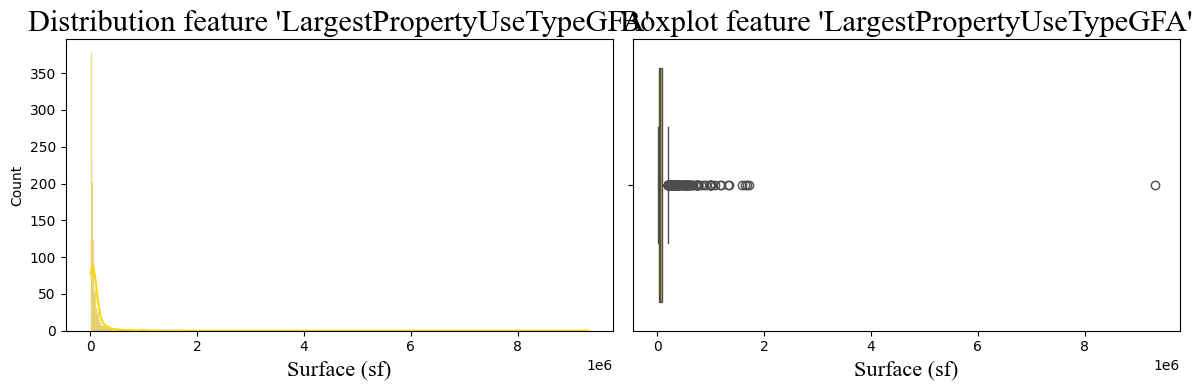

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,25649.0,99299.2,44078.0,92129.0,277968.6,2.8,23.18,739.5


In [57]:
# Liste des features d'energie
surface_all_list = [
    "PropertyGFATotal", 
    "PropertyGFAParking", 
    "PropertyGFABuilding(s)",
    "LargestPropertyUseTypeGFA"]

# Listes des features de surface avec Nan
surface_nan_list = feature_nan_list[-1]
print(surface_nan_list, "\n")

# Courbe
plot_distribution(df_travail, surface_nan_list, colors_list[0], unit="Surface (sf)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_travail, surface_nan_list)
display(df_stat)

Nous allons utiliser l'imputation par le KNNImputer.

Nous allons d'abord utiliser un GridSearch pour calculer le nombre de voisin optimal pour l'imputation KNN

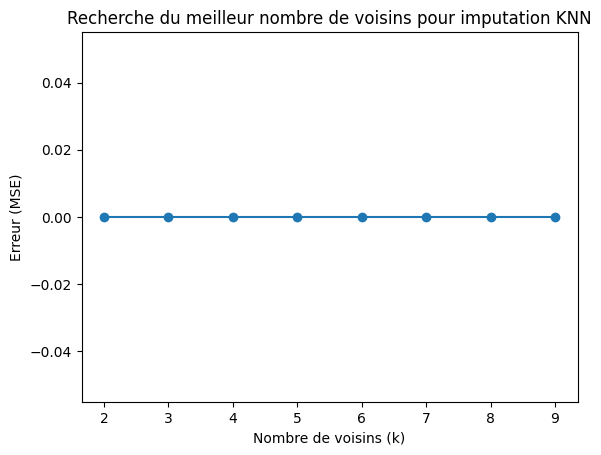

Le meilleur nombre de voisins est : 2


In [58]:
# Bornes du GridSearch
k_min, k_max = 2, 10

# Calcul du meilleur nombre de voisin pour l'imputation KNN
errors = determine_meilleur_voisin_knn(df_travail[surface_all_list], k_min, k_max)

Nous réalisons donc l'imputation KNN avec le nombre optimal de voisin trouvés : 2

In [59]:
# Créez un objet d'imputation KNN (2 voisins proches, valeurs manquantes=NaN)
imputerKNN = KNNImputer(n_neighbors=2, missing_values=np.nan)

# Entraînez et applique le modèle d'imputation KNN 
df_datas_imputed = pd.DataFrame(imputerKNN.fit_transform(df_travail[surface_all_list]), columns=df_travail[surface_all_list].columns)

Nous allons vérifier la distribution et les statitisques descriptives des colonnes après l'imputation.

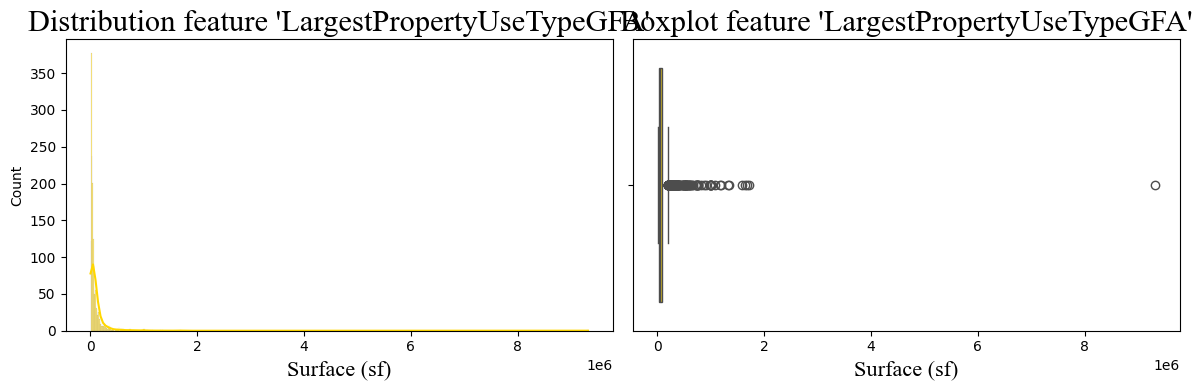

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,25641.8,99189.1,44039.0,92036.8,277727.8,2.8,23.2,740.7


In [60]:
# Courbe
plot_distribution(df_datas_imputed, surface_nan_list, colors_list[0], unit="Surface (sf)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_datas_imputed, surface_nan_list)
display(df_stat)

La distribution des données d'énergie qui présentaient des NaN ont été bien conservées suite à l'implémentation par KNN.

Vérifions les tailles des 2 dataframes (celui avec les NaN et celui avec les valeurs imputées)

In [61]:
# Affichage dataframe des données d'energie imputées
display(df_datas_imputed.head(3))
print(df_datas_imputed.shape)

,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA
0,88434.0,0.0,88434.0,88434.0
1,103566.0,15064.0,88502.0,83880.0
2,956110.0,196718.0,759392.0,756493.0


(1648, 4)


In [62]:
# Affichage dataframe des données quantitatives avec les NaN
display(df_travail.head(3))
print(df_travail.shape)

,OSEBuildingID,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,7,47.61220,-122.33799,1927,1.0,12,88434,0,88434,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,249.98,2.83
1,2,7,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,295.86,2.86
2,3,7,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,756493.0,43.0,96.0,97.7,241.89999,244.10001,72587024.0,73937112.0,21566554.0,49526664.0,1493800.0,2089.28,2.19


(1648, 23)


Les 2 dataframes présentent bien le même nombre de ligne, donc nous allons pouvoir remplacer les features du dataframe avec NaN par celui avec les  valeurs imputées.

In [63]:
# Remplacez features dans dataframe avec NaN par celles du dataframe imputé
df_travail.loc[:, surface_all_list] = df_datas_imputed.loc[:, surface_all_list]

Nous vérifions les NaN restant dans le dataframe d'imputation.

In [64]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_travail, True, False)

Valeurs manquantes (Nan) : 565 / 37904 données (1.49 %)
1 / 23 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
ENERGYSTARScore,565,34.280000


### ENERGYScore

Nous allons implémenter les NaN des features concernant des valeurs de ENERGYScore par des calculs de machine learning en utilisant l'algorithme KNN. 

Nous allons d'abord observer la distribution et les statitisques descriptives des colonnes avant l'imputation.

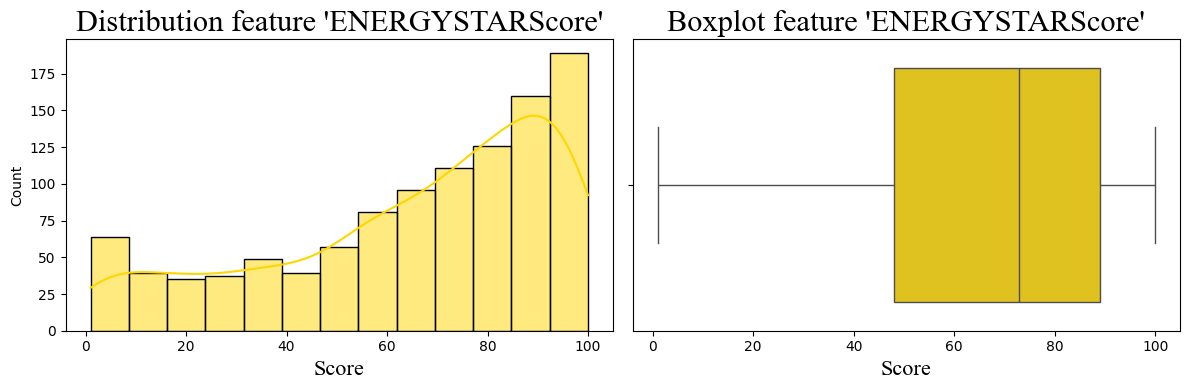

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,48.0,65.2,73.0,89.0,28.4,0.44,-0.77,-0.5


In [65]:
# Courbe
plot_distribution(df_travail, "ENERGYSTARScore", colors_list[0], unit="Score")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_travail, "ENERGYSTARScore")
display(df_stat)

Nous allons utiliser l'imputation par le KNNImputer.

Nous allons d'abord utiliser un GridSearch pour calculer le nombre de voisin optimal pour l'imputation KNN

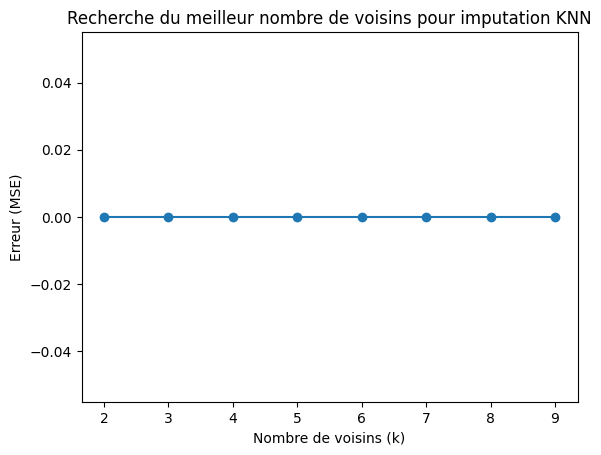

Le meilleur nombre de voisins est : 2


In [66]:
# Bornes du GridSearch
k_min, k_max = 2, 10

# Calcul du meilleur nombre de voisin pour l'imputation KNN
errors = determine_meilleur_voisin_knn(df_travail, k_min, k_max)

Nous réalisons donc l'imputation KNN avec le nombre optimal de voisin trouvés : 2

In [67]:
# Créez un objet d'imputation KNN (2 voisins proches, valeurs manquantes=NaN)
imputerKNN = KNNImputer(n_neighbors=2, missing_values=np.nan)

# Entraînez et applique le modèle d'imputation KNN 
df_datas_imputed = pd.DataFrame(imputerKNN.fit_transform(df_travail), columns=df_travail.columns)

Nous allons vérifier la distribution et les statitisques descriptives des colonnes après l'imputation.

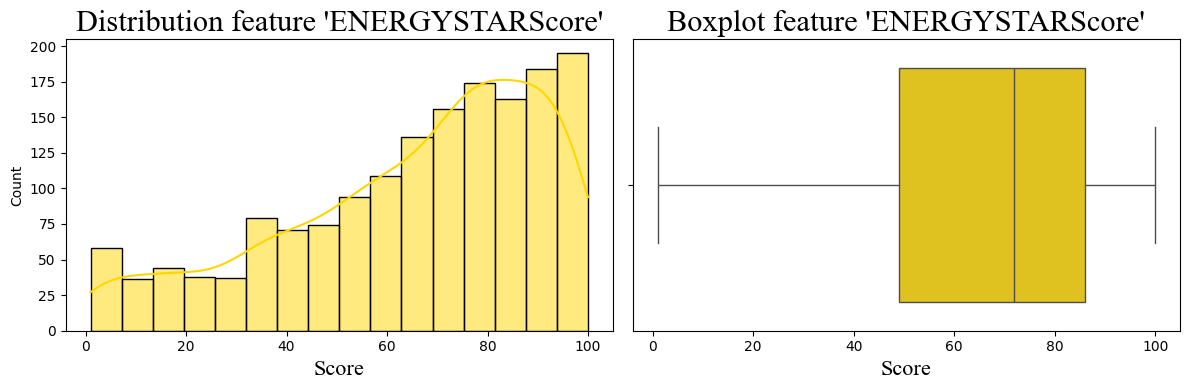

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,49.0,65.1,72.0,86.0,26.1,0.4,-0.75,-0.3


In [68]:
# Courbe
plot_distribution(df_datas_imputed, "ENERGYSTARScore", colors_list[0], unit="Score")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_datas_imputed, "ENERGYSTARScore")
display(df_stat)

La distribution des données d'ENERGYSTARScore qui présentaient des NaN a été bien conservée suite à l'implémentation par KNN.

Vérifions les tailles des 2 dataframes (celui avec les NaN et celui avec les valeurs imputées)

In [69]:
# Affichage dataframe des données d'ENERGYSTARScore imputées
display(df_datas_imputed.head(3))
print(df_datas_imputed.shape)

,OSEBuildingID,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1.0,7.0,47.61220,-122.33799,1927.0,1.0,12.0,88434.0,0.0,88434.0,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,249.98,2.83
1,2.0,7.0,47.61317,-122.33393,1996.0,1.0,11.0,103566.0,15064.0,88502.0,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,295.86,2.86
2,3.0,7.0,47.61393,-122.33810,1969.0,1.0,41.0,956110.0,196718.0,759392.0,756493.0,43.0,96.0,97.7,241.89999,244.10001,72587024.0,73937112.0,21566554.0,49526664.0,1493800.0,2089.28,2.19


(1648, 23)


In [70]:
# Affichage dataframe des données quantitatives avec les NaN
display(df_travail.head(3))
print(df_travail.shape)

,OSEBuildingID,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,7,47.61220,-122.33799,1927,1.0,12,88434,0,88434,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,249.98,2.83
1,2,7,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,295.86,2.86
2,3,7,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,756493.0,43.0,96.0,97.7,241.89999,244.10001,72587024.0,73937112.0,21566554.0,49526664.0,1493800.0,2089.28,2.19


(1648, 23)


Les 2 dataframes présentent bien le même nombre de ligne, donc nous allons pouvoir remplacer les features du dataframe avec NaN par celui avec les  valeurs imputées.

In [71]:
# Remplacez features dans dataframe avec NaN par celles du dataframe imputé
df_travail.loc[:, :] = df_datas_imputed.loc[:, :]

Nous vérifions les NaN restant dans le dataframe d'imputation.

In [72]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_travail, True, False)

Valeurs manquantes (Nan) : 0 / 37904 données (0.0 %)
0 / 23 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes


Nous avons imputé toutes les features quantitatives. Nous pouvons reintegrer ces features dans le dataframe des données nettoyées. 

In [73]:
# Copie du dataframe des données nettoyées
df_data_clean= df_data_clean_usetype_nan.copy()

# Remplacez features dans dataframe avec NaN par celles du dataframe imputées
df_data_clean.loc[:, feat_quanti_list] = df_travail

## <span style='background:green'>8/ Bilan dataset nettoyé</span>

Le dataset est entièrement nettoyé de ses valeurs manquantes.

Valeurs manquantes (Nan) : 0 / 54384 données (0.0 %)
0 / 33 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


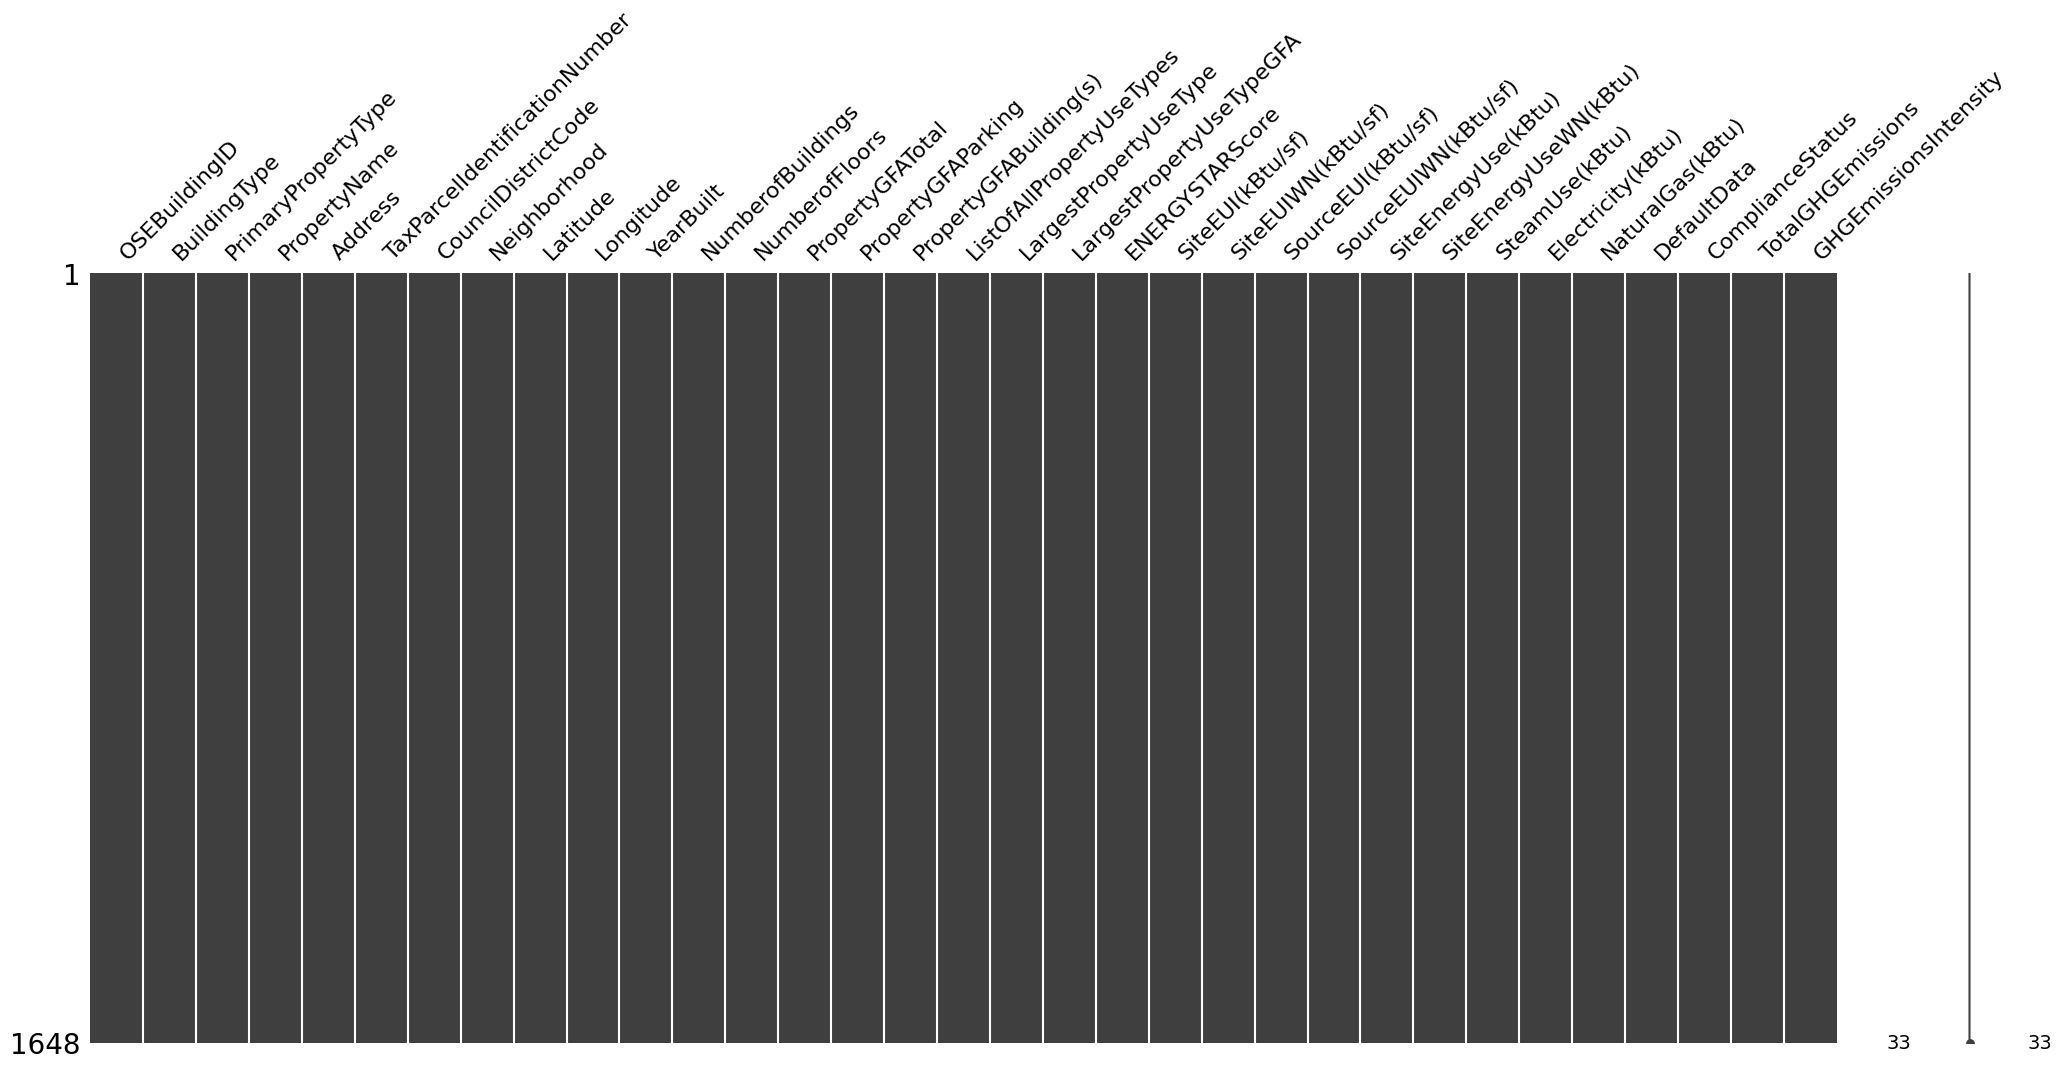

In [74]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean, False, True)

In [75]:
# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean, "df_data_clean", "Nan par imputation", 3)

Voici l'aspect de 'df_data_clean' après nettoyage Nan par imputation


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,60.0,81.7,84.3,182.50000,189.00000,7226362.5,7456910.0,2003882.0,3946027.0,1276453.0,False,Compliant,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,61.0,94.8,97.9,176.10001,179.39999,8387933.0,8664479.0,0.0,3242851.0,5145082.0,False,Compliant,295.86,2.86
2,3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,43.0,96.0,97.7,241.89999,244.10001,72587024.0,73937112.0,21566554.0,49526664.0,1493800.0,False,Compliant,2089.28,2.19


1648 ligne(s) x 33 colonne(s)



# <span style='background:blue'>Etape 3 : Analyse exploratoire</span>
___

## <span style='background:green'>1/ Analyses univariées</span>

### Types de batiment

Nous observons la répartition des types de batiment dans le dataset. 

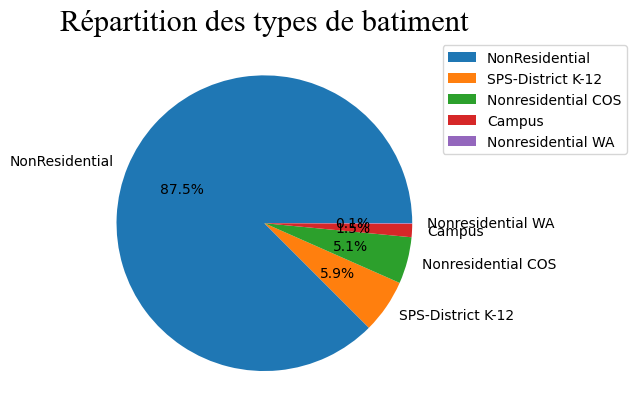

In [76]:
# Compte les ID de batiment par type de batiment (ordre décroissant)
repartition_type_batiment = df_data_clean.groupby(by='BuildingType')['OSEBuildingID'].nunique().sort_values(ascending=False)

# Convert index to list of strings
labels = repartition_type_batiment.index.tolist()

# Diagramme camembert 
plt.pie(repartition_type_batiment, labels=labels, 
    autopct='%1.1f%%') 

# Ajout du titre et légende
plt.title("Répartition des types de batiment", fontdict=font_title)
plt.legend(loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### Types d'usage

Nous allons explorer la répartition des types d'usage dans 'LargestPropertyUseType'. 

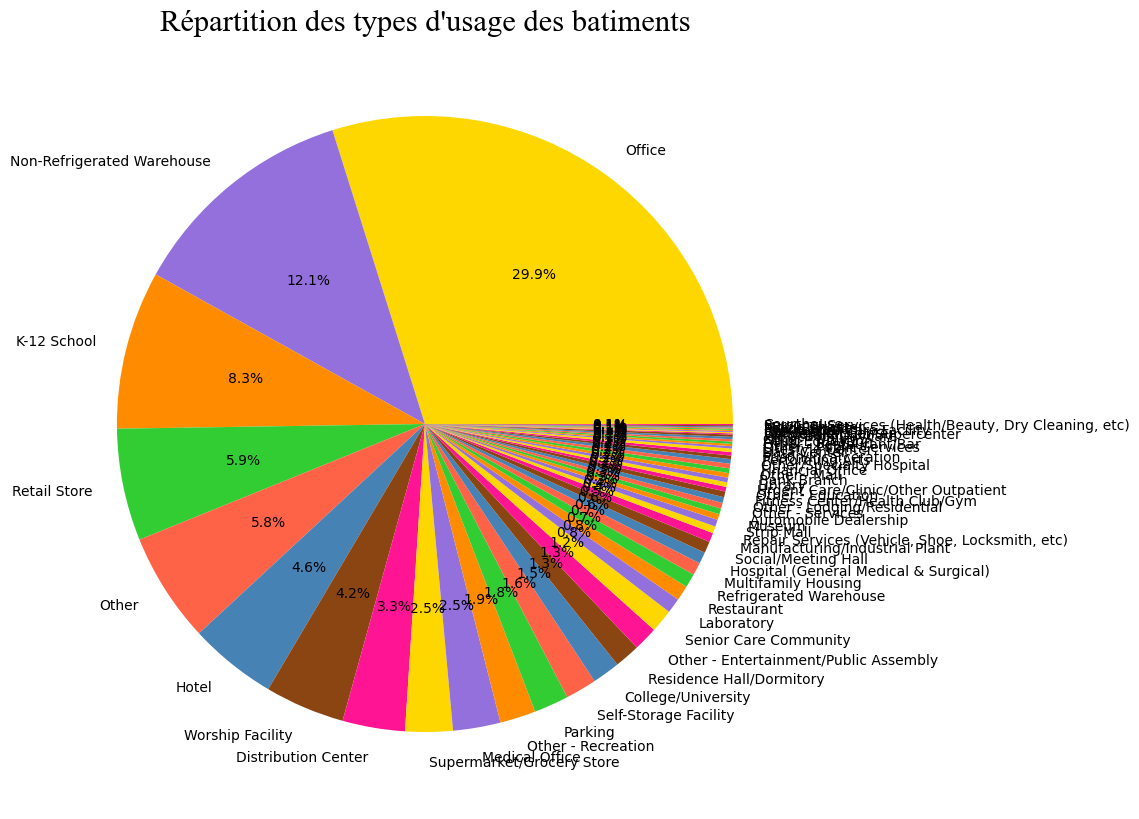

In [77]:
# Compter les occurrences par type d'usage dans feature 'LargestPropertyUseType'
counts = df_data_clean['LargestPropertyUseType'].value_counts()

# Créer le pie chart
plt.figure(figsize=(10, 10))
plt.pie(counts, labels=counts.index.tolist(), autopct='%1.1f%%', colors=colors_list)

# Ajout du titre du graphique
plt.title("Répartition des types d'usage des batiments", fontdict=font_title)
plt.show()

Les bureaux sont les types d'usage les plus récurrents dans le dataset. Ils représentent presque un tiers des types d'usage.

Plus de la moitié des types d'usage sont soit des bureaux, soit des entrepôts non-réfrigérés, soit des écoles.

Observons le top 10 des types d'usage les plus récurrents dans le dataset.

C:\Users\pierr\AppData\Local\Temp\ipykernel_16900\4146890388.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(top_counts.index, rotation=45, ha='right')


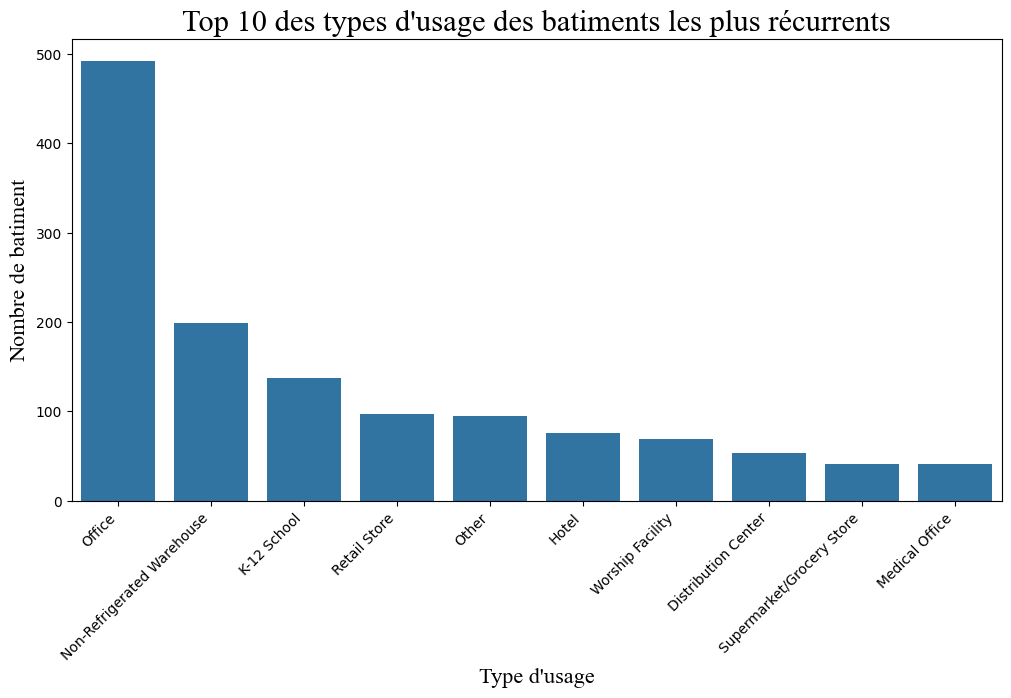

In [78]:
# Nombre des premières valeurs à afficher
top_nombre = 10
top_counts = counts.head(top_nombre)

# Créer un barplot avec Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=top_counts.index, y=top_counts.values)

# Ajout du titre du graphique, des axes X et Y
plt.title("Top {} des types d'usage des batiments les plus récurrents".format(top_nombre), fontdict=font_title)
plt.xlabel("Type d'usage", fontdict=font_axe)
plt.ylabel("Nombre de batiment", fontdict=font_axe)
plt.gca().set_xticklabels(top_counts.index, rotation=45, ha='right')
plt.show()

### Features cibles :  émissions de CO2 et la consommation totale d’énergie

Nous devons prédire les émissions de CO2 et la consommation totale d’énergie. Pour cela nous identifions les 2 features cibles dans le dataset: 
- Emission de CO2 : **'TotalGHGEmissions'** exprimé en tonnes métriques d'équivalent de dioxyde de carbone (tCO2e)
<br><br>
- Consommation totale d’énergie : **'SiteEnergyUse(kBtu)'**

#### TotalGHGEmissions

Nous appliquons le **test Shapiro-Wilk** pour vérifier si la distribution est normale. Pour cela, nous devons émettre les 2 hypothèses de ce test :

**Hypothèse nulle (H0) : la population est distribuée normalement selon la loi gaussienne.**

Hypothèse alternative (HA) : la population n'est pas distribuée normalement selon la loi gaussienne.

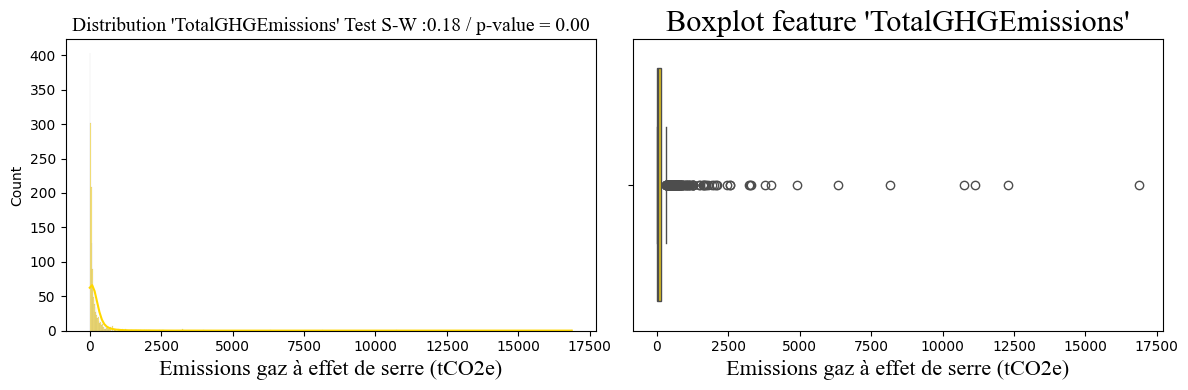

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,20.5,186.5,49.9,143.6,755.6,4.05,14.14,244.6


In [79]:
# Feature analysée
feature_analyzed = "TotalGHGEmissions"

# Histogramme
plot_distribution(df_data_clean, feature_analyzed, colors_list[0], shapiro_wilk=True, unit="Emissions gaz à effet de serre (tCO2e)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_data_clean, feature_analyzed)
display(df_stat)

La p-value < 0.05, nous pouvons rejeter l'hypothèse nulle. 

**Les données de cet feature cible ne sont pas distribuées normalement.**

Nous remarquons qu'il y a des outliers qui sont très éloignées de la moyenne et la médiane. Pour autant, ces valeurs semblent atypiques mais pas aberrantes. En effet, les relevés officiels de l'Agence de protection de l'environnement des États-Unis (Environmental Protection Agency, EPA) affichent une quantité d'émissions de gaz à effet de serre de l'ordre de 87_000 tCO2e pour le seul campus de l'université de Washington basée à Seattle en 2016. Notre plus grande valeur se situe aux alentours de 17_500 tCO2e soit environ 5 fois moins d'émission.<br><br>
**Toutes nos données d'émission de CO2 sont donc probables.** 

**Source:**<br>
[GHGEmissions of University of Washington Seattle Campus university in 2016 by EPA](https://ghgdata.epa.gov/ghgp/service/facilityDetail/2016?id=1002682&ds=E&et=&popup=true)

Nous allons donc conserver ces outliers pour la suite des traitements et nous transformons la distribution de cet feature cible en appliquant une transformation logarithmique.

c:\Users\pierr\VSC_Projects\Projet4_OCR_DataScientist\env\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\pierr\VSC_Projects\Projet4_OCR_DataScientist\env\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


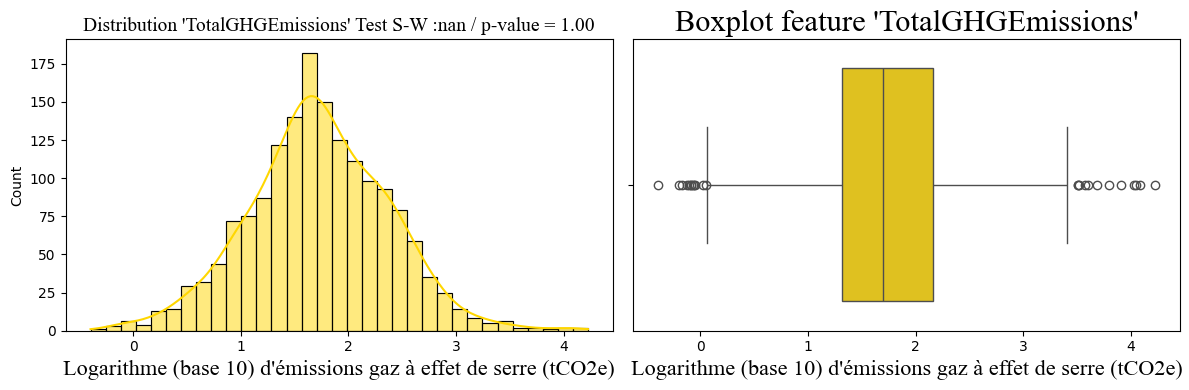

In [80]:
# Copie du dataframe
df_data_log = df_data_clean.copy()

# Transformation logarithmique (log décimal)
df_data_log[feature_analyzed] = np.log10(df_data_clean[feature_analyzed])

# Histogramme
plot_distribution(df_data_log, feature_analyzed, colors_list[0], shapiro_wilk=True, unit="Logarithme (base 10) d'émissions gaz à effet de serre (tCO2e)")

Les données d'émission de CO2 sont désormais distribuées normalement (p-value S-W > 0,05).

#### SiteEnergyUse(kBtu)

Nous appliquons le **test Shapiro-Wilk** pour vérifier si la distribution est normale.

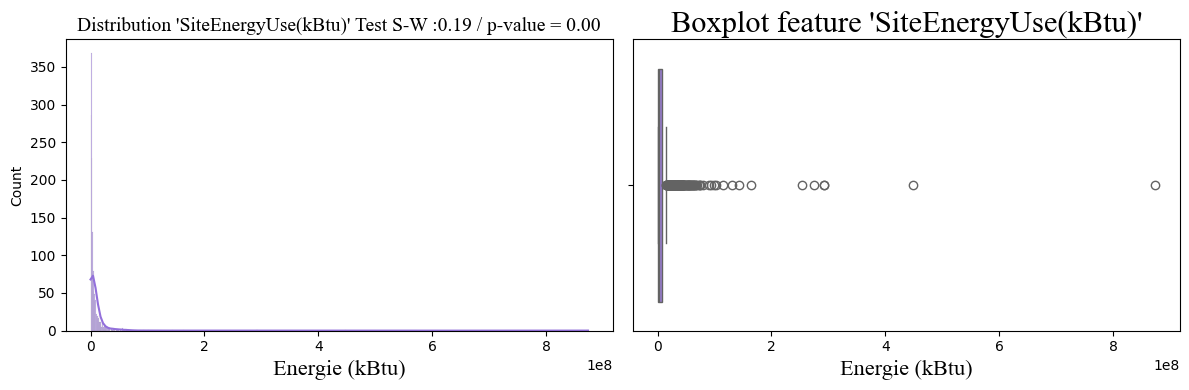

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,1251083.4,8476726.3,2582214.4,6928335.0,30375344.3,3.58,17.99,441.6


In [81]:
# Feature analysée
feature_analyzed = "SiteEnergyUse(kBtu)"

# Histogramme
plot_distribution(df_data_clean, feature_analyzed, colors_list[1], shapiro_wilk=True, unit="Energie (kBtu)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_data_clean, feature_analyzed)
display(df_stat)

La p-value < 0.05, nous pouvons rejeter l'hypothèse nulle. 

**Les données de cet feature cible ne sont pas distribuées normalement.**

Nous remarquons qu'il y a des outliers qui sont très éloignées de la moyenne et la médiane. Pour autant, ces valeurs semblent atypiques mais pas aberrantes. En effet, le rapport d'analyse des consommations énergétiques des batiments de la ville de Seattle de 2013 affichait une quantité de consommation d'énergie de 15,7 milliards de kBtu pour toute la ville. Si nous considérons les types d'usage des batiments, ceux qui consommaient le plus d'énergie étaient les bureaux avec 3,4 milliard de kBtu pour les 431 bureaux de la ville. Notre plus grande valeur se situe aux alentours de 800 millions kBtu. La probabilité qu'un seul batiment puisse être un gros contributeur de cette consommation n'est pas nulle. <br><br>
**Toutes nos données de consommation d'énergie sont donc probables.** 

**Source:**<br>
[Rapport d'analyse des consommations énergétiques des batiments de la ville de Seattle de 2013](https://www.seattle.gov/documents/departments/ose/ebr-2013-report.pdf)

Nous allons donc conserver ces outliers pour la suite des traitements et nous transformons la distribution de cet feature cible en appliquant une transformation logarithmique.

c:\Users\pierr\VSC_Projects\Projet4_OCR_DataScientist\env\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


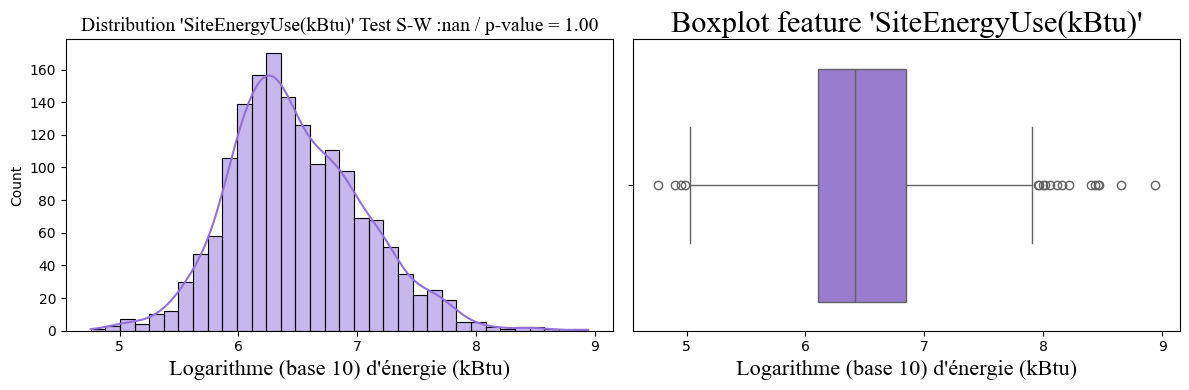

In [82]:
# Transformation logarithmique (log décimal)
df_data_log[feature_analyzed] = np.log10(df_data_clean[feature_analyzed])

# Histogramme
plot_distribution(df_data_log, feature_analyzed, colors_list[1], shapiro_wilk=True, unit="Logarithme (base 10) d'énergie (kBtu)")

Les données de consommation totale d'énergie sont désormais distribuées normalement (p-value S-W > 0,05).

### Ancienneté des batiments

Tout d'abord, nous observons la distribution des années de construction des batiments dans le dataset.

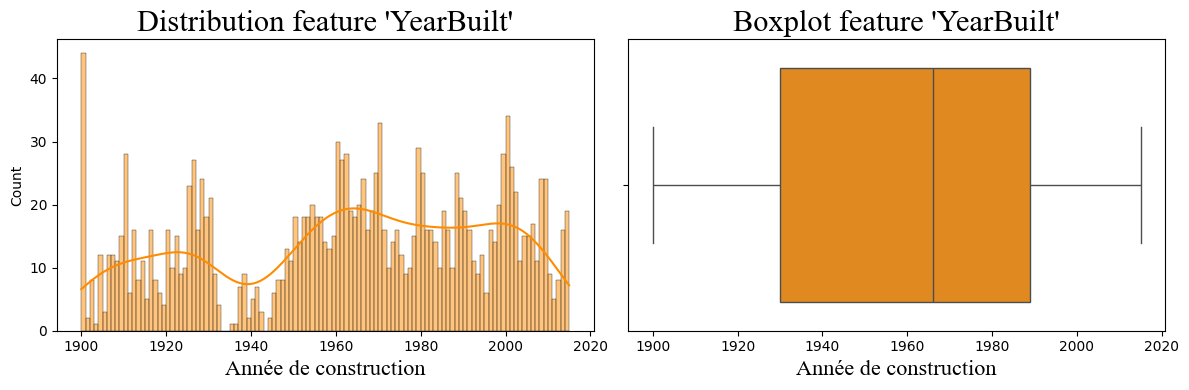

In [83]:
# Histogramme
plot_distribution(df_data_clean, "YearBuilt", colors_list[2], binwidth=1, unit="Année de construction")

Aucun outlier n'est constaté. Nous utilisons ces données pour créer une nouvelle feature qui indique l'ancienneté des batiments.

In [84]:
df_data_log["AncienneteBatiment"] = 2016 - df_data_log["YearBuilt"]

nous observons la distribution de cette nouvelle feature (directement corrélée à celle des années de constructions).

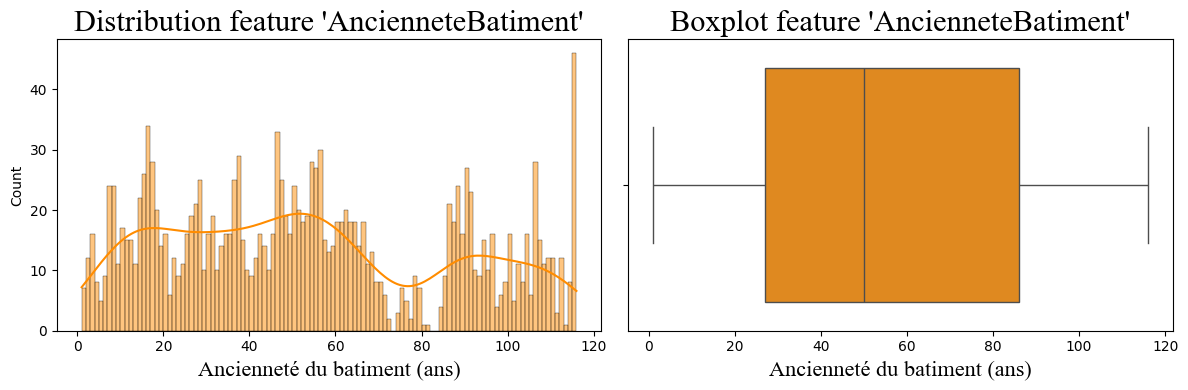

,Q1,moyenne,médiane,Q3,ecart-type,CV,skewness,kurtosis
0,27.0,53.8,50.0,86.0,32.6,0.61,0.3,-1.0


In [85]:
# Histogramme
plot_distribution(df_data_log, "AncienneteBatiment", colors_list[2], binwidth=1, unit="Ancienneté du batiment (ans)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_data_log, "AncienneteBatiment")
display(df_stat)

Résumé de la distribution de l'ancienneté des batiments : 

- **Aspect** : distribution **trimodale** => 3 zones de fortes concentrations (autour de 16, 50 et 90 ans).
  
- **Tendance centrale** : La **moyenne** et la **médiane** sont proches de 50-55 ans.
  
- **Dispersion** : les données forment un groupe hétérogène (CV > 15%).
  
- **Forme** : les données sont étalées à droite (skewness>0) et les observations sont plus aplaties que la loi normale (kurtosis<0).

Nous supprimons la feature des années de construction des batiments car elle est redondante avec la feature de l'ancienneté des batiments.

In [86]:
# Suppression des features redondantes
df_data_log = df_data_log.drop(columns=["YearBuilt"])


## <span style='background:green'>2/ Analyses multivariées</span>

### Matrice de corrélation

Nous affichons une matrice de corrélation de toutes les variables quantitatives de notre dataset pour pouvoir détecter les corrélations linéaires les plus visibles grâce aux coefficients de corrélation de Pearson. 

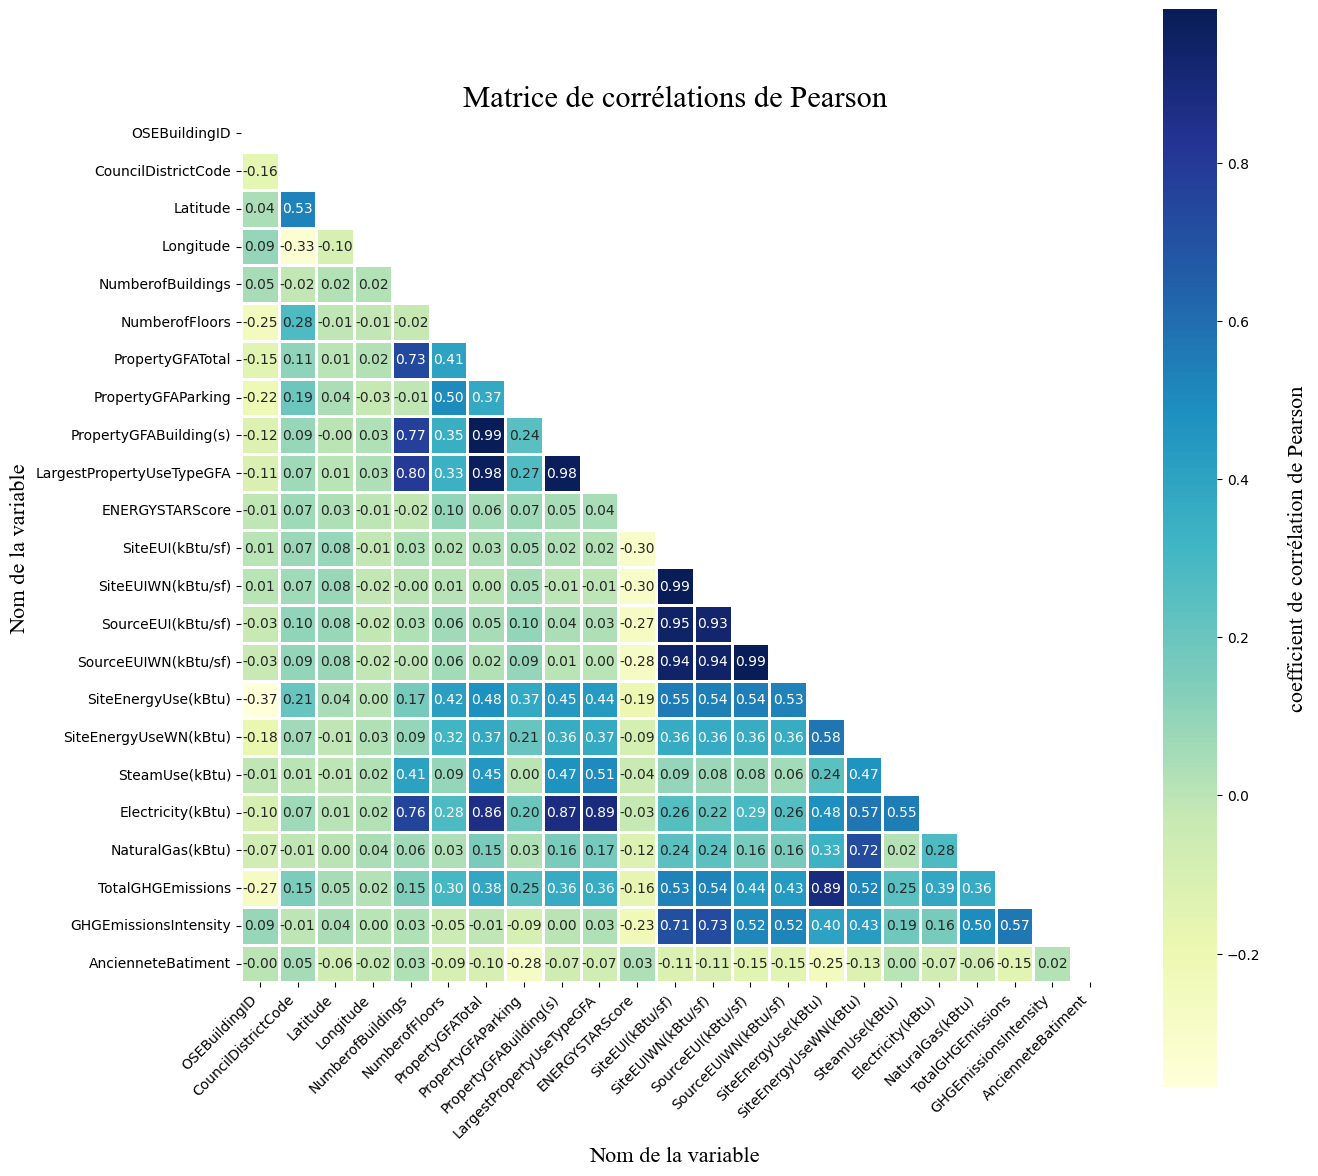

In [87]:
# Comptage du nombre de feature quantitatives
feat_quanti_list = df_data_log.select_dtypes(include=['int', 'float']).columns

# Matrice des corrélations
corr_mat = df_data_log[feat_quanti_list].corr()

# Créer un masque pour masquer les valeurs au-dessus de la diagonale
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# heatmap
fig, ax = plt.subplots(figsize=(14,14))
heatmap = sns.heatmap(corr_mat, square=True, linewidths=1, annot=True, fmt=".2f", cmap='YlGnBu', mask=mask, ax=ax)

# Ajout du titre du graphique, des axes et de la colorbar
plt.title("Matrice de corrélations de Pearson", fontdict=font_title)
plt.xlabel("Nom de la variable", fontdict=font_axe)
plt.ylabel("Nom de la variable", fontdict=font_axe)
plt.xticks(rotation=45, ha='right')
cbar = heatmap.collections[0].colorbar
cbar.set_label('coefficient de corrélation de Pearson', labelpad=20, fontdict=font_axe)  
plt.show()

Perumutation features importances

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Séparez les caractéristiques (X) de la cible (y)
X = df_data_log.drop('target_column', axis=1)  # Remplacez 'target_column' par le nom de votre colonne cible
y = df_data_log['target_column']

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînez un modèle (par exemple, Random Forest)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Évaluez la performance initiale du modèle
y_pred = model.predict(X_test)
initial_mse = mean_squared_error(y_test, y_pred)

# Calculez l'importance des caractéristiques
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Récupérez les scores d'importance
importance_scores = result.importances_mean

# Affichez l'importance des caractéristiques
for i, col in enumerate(X.columns):
    print(f"Feature '{col}': Importance = {importance_scores[i]:.4f}")

# Vous pouvez trier les caractéristiques par importance
sorted_indices = np.argsort(importance_scores)[::-1]

# Affichez les caractéristiques triées par importance
for i in sorted_indices:
    print(f"Feature '{X.columns[i]}': Importance = {importance_scores[i]:.4f}")
